# Prophet library

In [12]:
import pandas as pd
import numpy as np
from prophet import Prophet
from matplotlib import pyplot as plt
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import itertools
import math

UNUSABLE = [
    "Rural population living in areas where elevation is below 5 meters (% of total population)",
    "Access to electricity, rural (% of rural population)",
    "Surface area (sq. km)",
    "Rural land area (sq. km)",
    "Land area (sq. km)",
    "Average precipitation in depth (mm per year)",
    "Agricultural irrigated land (% of total agricultural land)",
    "Rural land area where elevation is below 5 meters (% of total land area)",
    "Rural land area where elevation is below 5 meters (sq. km)"
]

In [2]:
def prepare_wide_dataset(df):
    if 'Indicator Name' not in df.columns:
        raise ValueError("Il DataFrame deve contenere una colonna 'Indicator Name'")

    original_indicator_order = df['Indicator Name'].unique()
    
    year_cols = [col for col in df.columns if str(col).isdigit()]
    df_long = df.melt(id_vars='Indicator Name', value_vars=year_cols,
                    var_name='Year', value_name='Value')

    df_wide = df_long.pivot(index='Year', columns='Indicator Name', values='Value').reset_index()
    
    df_wide['ds'] = pd.to_datetime(df_wide['Year'], format='%Y')
    df_wide.drop(columns='Year')
    #df_wide = df_wide.sort_values('Year').reset_index(drop=True)
    df_wide.columns.name = None
    
    # rimuovo variabili inutilizzabili
    unusable_cols = [col for col in df_wide.columns if col in UNUSABLE]
    if unusable_cols:
        df_wide = df_wide.drop(columns=unusable_cols)

    final_column_order = ['ds']
    for indicator in original_indicator_order:
        if indicator in df_wide.columns:
            final_column_order.append(indicator)
    df_wide = df_wide[final_column_order]
    
    return df_wide

In [3]:
df = pd.read_excel('./italy_values_dataset.xlsx')
wide_df = prepare_wide_dataset(df)
# display(wide_df.head())

In [4]:
def preprocessing(col, df):
    serie = df[['ds', col]].rename(columns={col: 'y'}).dropna(subset=['y']).reset_index(drop=True)
    return serie

In [ ]:
def fit_adaptive_prophet(df_prophet):
    """
    Funzione robusta che:
    1. Adatta i parametri di CV alla lunghezza dei dati.
    2. Esegue un grid search per 'changepoint_prior_scale'.
    3. Restituisce il modello finale ottimizzato.
    """
    n_data_points = len(df_prophet)
    if n_data_points < 20:
        print(f"ATTENZIONE: Pochi dati ({n_data_points}). Cross-Validation saltata.")
        # Se hai meno di 20 punti, il tuning è inaffidabile.
        # Fitta solo un modello base.
        m_final = Prophet(
            changepoint_prior_scale=0.05, # Usa default
            interval_width=0.95,
            yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False
        ).fit(df_prophet)
        return m_final, {'changepoint_prior_scale': 0.05, 'cv_skipped': True}

    # Calcola i periodi in giorni (assumendo dati annuali)
    initial_years = math.floor(n_data_points * 0.7)
    horizon_years = math.floor(n_data_points * 0.2)
    period_years = math.floor(n_data_points * 0.1)

    # Assicurati che horizon e period siano almeno 1 anno
    if horizon_years == 0: horizon_years = 1
    if period_years == 0: period_years = 1
        
    initial_td = pd.to_timedelta(str(initial_years * 365) + ' days')
    horizon_td = pd.to_timedelta(str(horizon_years * 365) + ' days')
    period_td = pd.to_timedelta(str(period_years * 365) + ' days')

    print(f"Serie con {n_data_points} punti. Parametri CV impostati a:")
    print(f"Initial: {initial_years} anni, Horizon: {horizon_years} anni, Period: {period_years} anni")

    # Regola 2: Griglia di parametri
    param_grid = {
        'growth': ['linear'],
        'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5] # Griglia per il tuning
    }
    
    # Regola 3 (Esempio): Se la serie è corta, sii meno flessibile
    if n_data_points < 30:
        print("Serie corta, testo solo changepoint bassi per evitare overfitting.")
        param_grid['changepoint_prior_scale'] = [0.01, 0.05] # Riduci la griglia
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    
    rmses = []
    
    for params in all_params:
        m = Prophet(
            **params, 
            interval_width=0.95,
            yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False
        ).fit(df_prophet)
        
        try:
            df_cv = cross_validation(m, initial=initial_td, period=period_td, horizon=horizon_td, parallel="processes")
            df_p = performance_metrics(df_cv)
            rmses.append(df_p['rmse'].values[0])
        except Exception as e:
            print(f"CV fallita per {params}: {e}")
            rmses.append(float('inf'))

    if min(rmses) == float('inf'):
        print("Tutte le CV sono fallite. Restituisco un modello con parametri default.")
        best_params = {'growth': 'linear', 'changepoint_prior_scale': 0.05}
    else:
        best_params_index = rmses.index(min(rmses))
        best_params = all_params[best_params_index]
    
    print(f"PARAMETRI MIGLIORI TROVATI: {best_params}")

    m_final = Prophet(
        **best_params,
        interval_width=0.95,
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False
    ).fit(df_prophet)

    return m_final, best_params

In [39]:
def generate_forecast_and_plots(col, model, future_periods=15):
    print(f"Creazione previsioni per {future_periods} periodi futuri")
    
    future = model.make_future_dataframe(periods=future_periods, freq='AS') # 'AS' = Annual Start (1° Gennaio)
    forecast = model.predict(future)

    df_hist = preprocessing(col, wide_df)
    split_idx = int(len(df_hist) * 0.8)
    train = df_hist[:split_idx]
    test = df_hist[split_idx:]
    # allineo le previsioni con i dati storici per valutazione
    merge_cols = ['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']
    fcst_hist = forecast[forecast['ds'].isin(df_hist['ds'])][merge_cols].merge(df_hist, on='ds', how='left')

    # calcolo metriche sul test set (se presente)
    if not test.empty:
        test_fcst = fcst_hist[fcst_hist['ds'].isin(test['ds'])].dropna(subset=['y', 'yhat'])
        if not test_fcst.empty:
            mse = np.mean((test_fcst['y'] - test_fcst['yhat'])**2)
            rmse = np.sqrt(mse)
            mae = np.mean(np.abs(test_fcst['y'] - test_fcst['yhat']))
            mape = np.mean(np.abs((test_fcst['y'] - test_fcst['yhat']) / test_fcst['y']))
            metrics = dict(mse=mse, rmse=rmse, mae=mae, mape=mape)
        else:
            metrics = dict(mse=np.nan, rmse=np.nan, mae=np.nan, mape=np.nan)
    else:
        metrics = dict(mse=np.nan, rmse=np.nan, mae=np.nan, mape=np.nan)

    print(f"Validation metrics (test) for {col}: {metrics}")

    # creo figura con 3 righe x 1 colonna e disegno i tre plot richiesti
    fig, axes = plt.subplots(3, 1, figsize=(12, 14))
    ax1, ax2, ax3 = axes

    # Plot 1: forecast completo con intervallo e dati osservati
    ax1.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='C0')
    ax1.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='C0', alpha=0.2)
    ax1.scatter(df_hist['ds'], df_hist['y'], color='k', s=20, label='Observed', zorder=5)
    if not test.empty:
        ax1.axvline(test['ds'].iloc[0], color='gray', linestyle='--', label='Test start')
    ax1.set_title(f"Prophet Forecast for {col}")
    ax1.set_ylabel(col)
    ax1.legend(loc='upper left')
    ax1.grid(True)
    # annotazione metriche
    try:
        ax1.text(0.02, 0.03, f"RMSE: {metrics['rmse']:.3f}  MAE: {metrics['mae']:.3f}  MAPE: {metrics['mape']:.3f}",
                transform=ax1.transAxes, fontsize=9, bbox=dict(facecolor='white', alpha=0.6))
    except Exception:
        pass

    # Plot 2: solo trend (con banda di incertezza se disponibile)
    ax2.plot(forecast['ds'], forecast['trend'], label='Trend', color='C1')
    if 'trend_lower' in forecast.columns and 'trend_upper' in forecast.columns:
        ax2.fill_between(forecast['ds'], forecast['trend_lower'], forecast['trend_upper'], color='C1', alpha=0.2)
    ax2.set_title(f"Trend Analysis - {col}")
    ax2.set_ylabel("Trend")
    ax2.grid(True)
    ax2.legend(loc='upper left')

    # Plot 3: forecast con changepoints evidenziati
    ax3.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='C0')
    ax3.scatter(df_hist['ds'], df_hist['y'], color='k', s=20, label='Observed', zorder=5)
    try:
        add_changepoints_to_plot(ax3, model, forecast)
    except Exception:
        # fallback: se add_changepoints_to_plot fallisce, lo ignoriamo
        pass
    ax3.set_title(f"Forecast with Changepoints for {col}")
    ax3.set_ylabel(col)
    ax3.grid(True)
    ax3.legend(loc='upper left')
    plt.tight_layout()
    
    plt.show()
    return forecast

siccome i miei dati sono annuali non posso studiare la stagionalità nè l'holiday effect quindi il modello si baserà principalmente sul trend generale

------------------------------RURAL POPULATION (% OF TOTAL POPULATION)------------------------------
Serie con 65 punti. Parametri CV impostati a:
Initial: 45 anni, Horizon: 13 anni, Period: 6 anni
PARAMETRI MIGLIORI TROVATI: {'growth': 'linear', 'changepoint_prior_scale': 0.5}
Creazione previsioni per 15 periodi futuri
Validation metrics (test) for Rural population (% of total population): {'mse': np.float64(0.0004476752410800082), 'rmse': np.float64(0.02115833738931318), 'mae': np.float64(0.017123469145840724), 'mape': np.float64(0.0005905436906419063)}


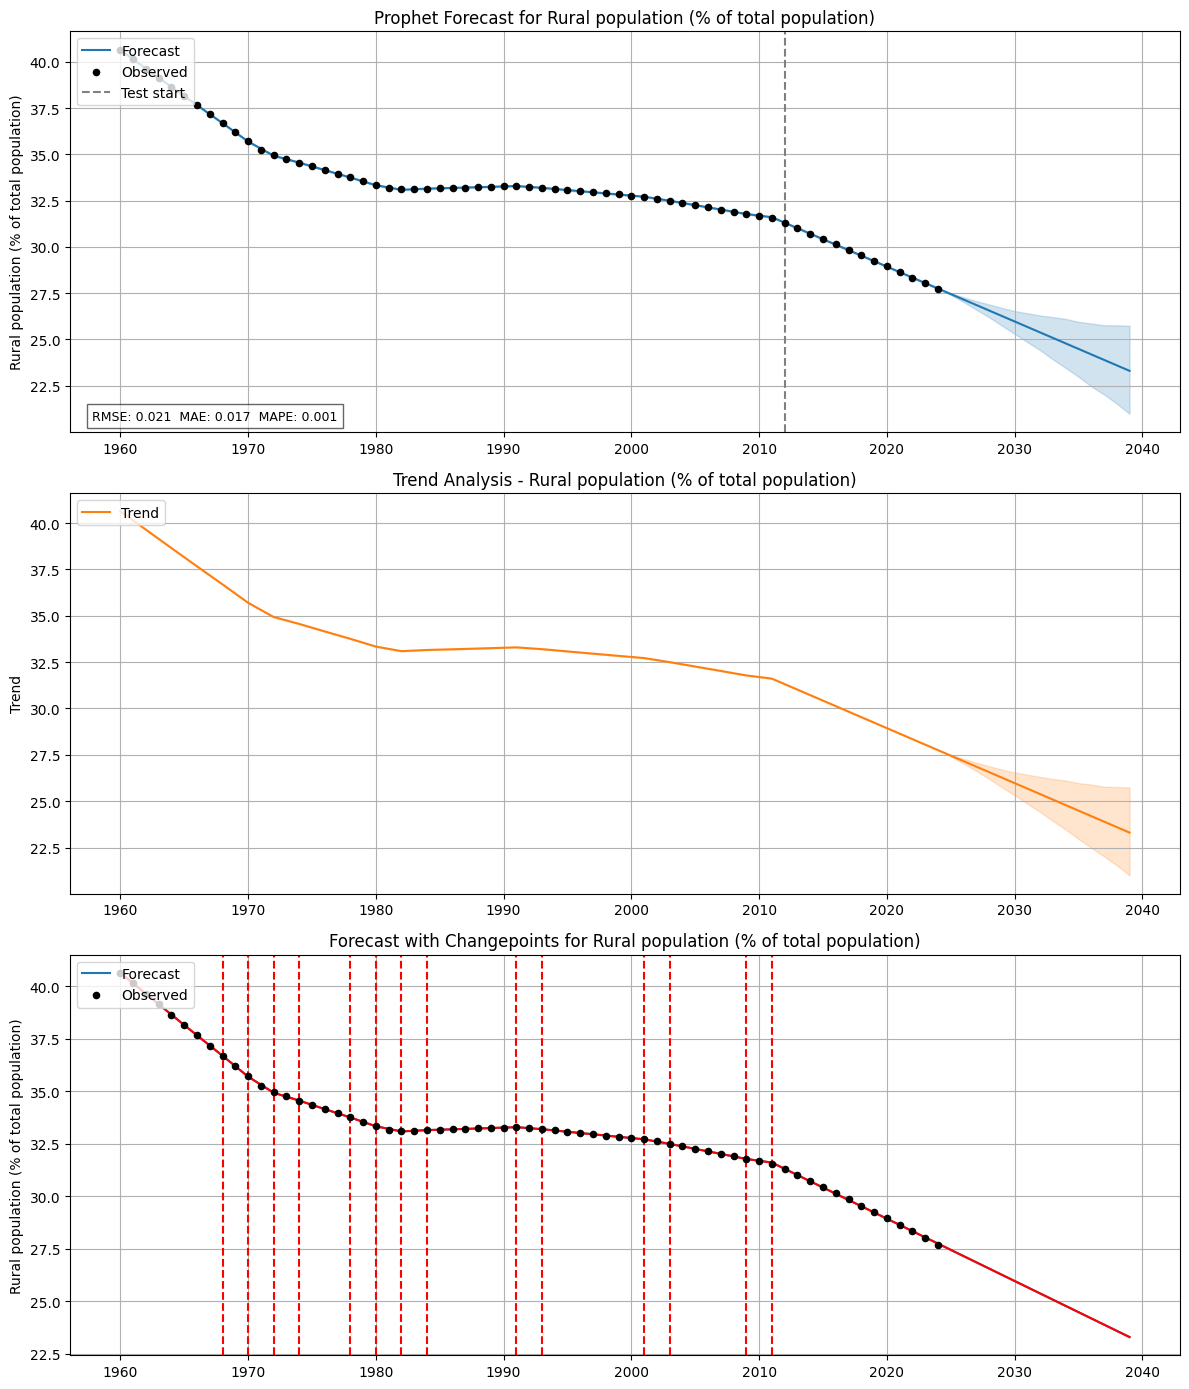



------------------------------RURAL POPULATION GROWTH (ANNUAL %)------------------------------
Serie con 64 punti. Parametri CV impostati a:
Initial: 44 anni, Horizon: 12 anni, Period: 6 anni
PARAMETRI MIGLIORI TROVATI: {'growth': 'linear', 'changepoint_prior_scale': 0.5}
Creazione previsioni per 15 periodi futuri
Validation metrics (test) for Rural population growth (annual %): {'mse': np.float64(0.10478171069932055), 'rmse': np.float64(0.32370003197299896), 'mae': np.float64(0.2954822986455256), 'mape': np.float64(0.26060651631455956)}


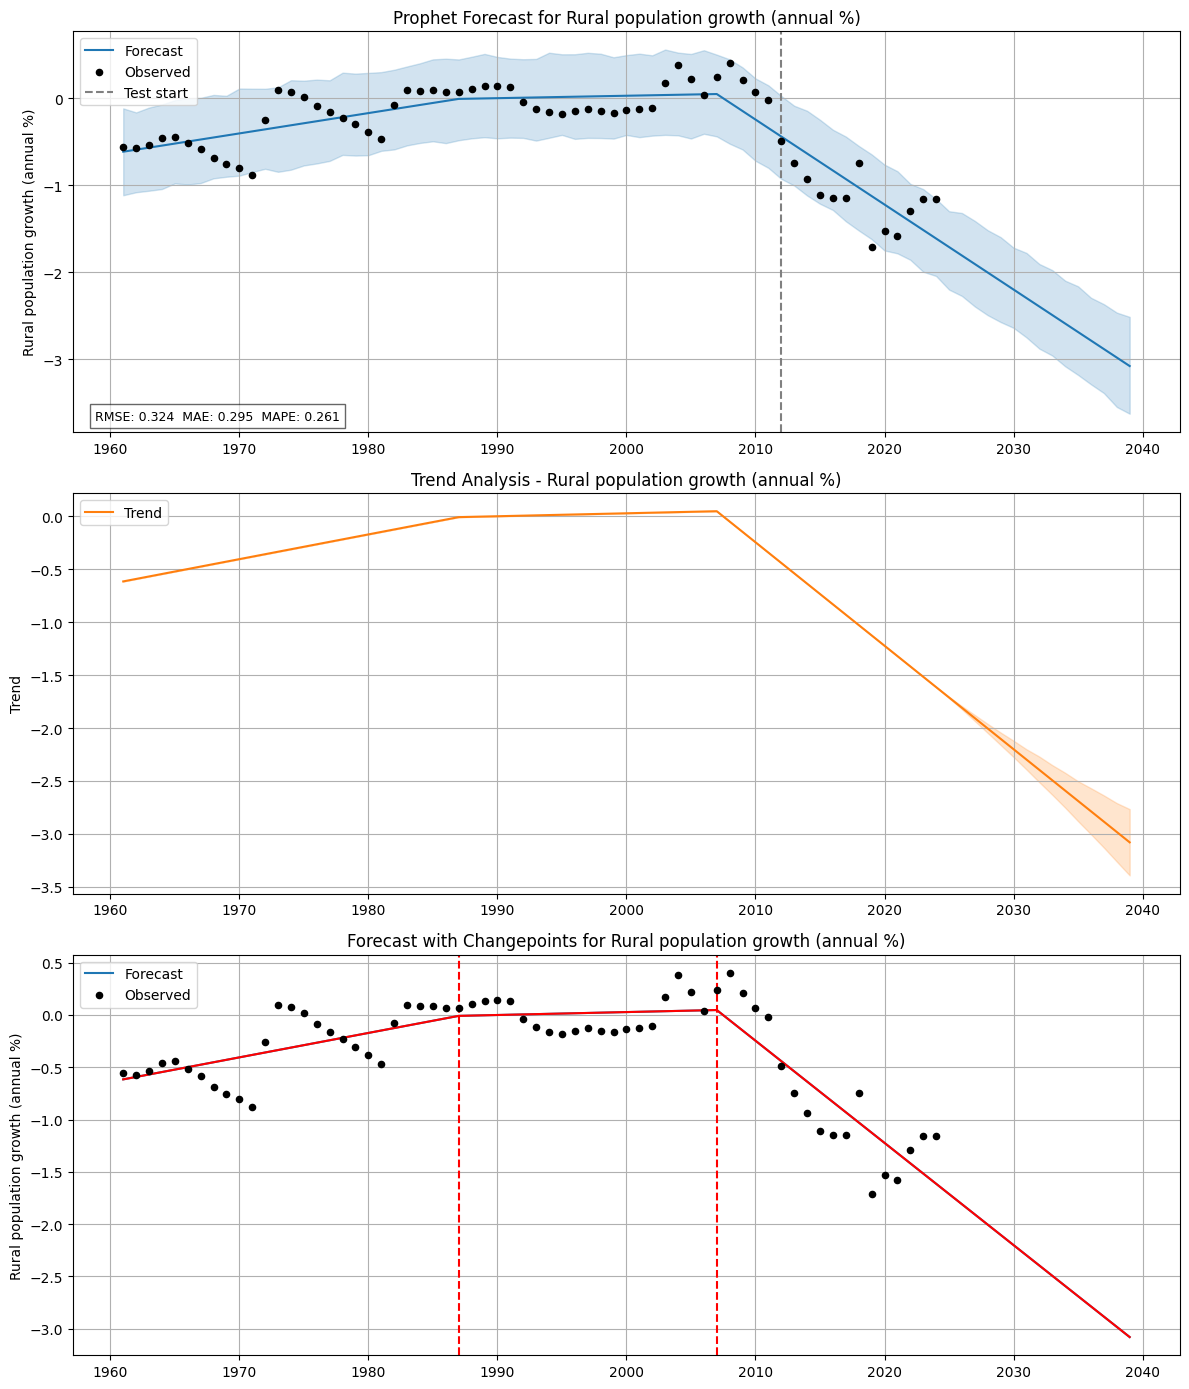



------------------------------RURAL POPULATION------------------------------
Serie con 65 punti. Parametri CV impostati a:
Initial: 45 anni, Horizon: 13 anni, Period: 6 anni
PARAMETRI MIGLIORI TROVATI: {'growth': 'linear', 'changepoint_prior_scale': 0.01}
Creazione previsioni per 15 periodi futuri
Validation metrics (test) for Rural population: {'mse': np.float64(522823670034.9288), 'rmse': np.float64(723065.4673229312), 'mae': np.float64(605176.6705209211), 'mape': np.float64(0.03501558008786447)}


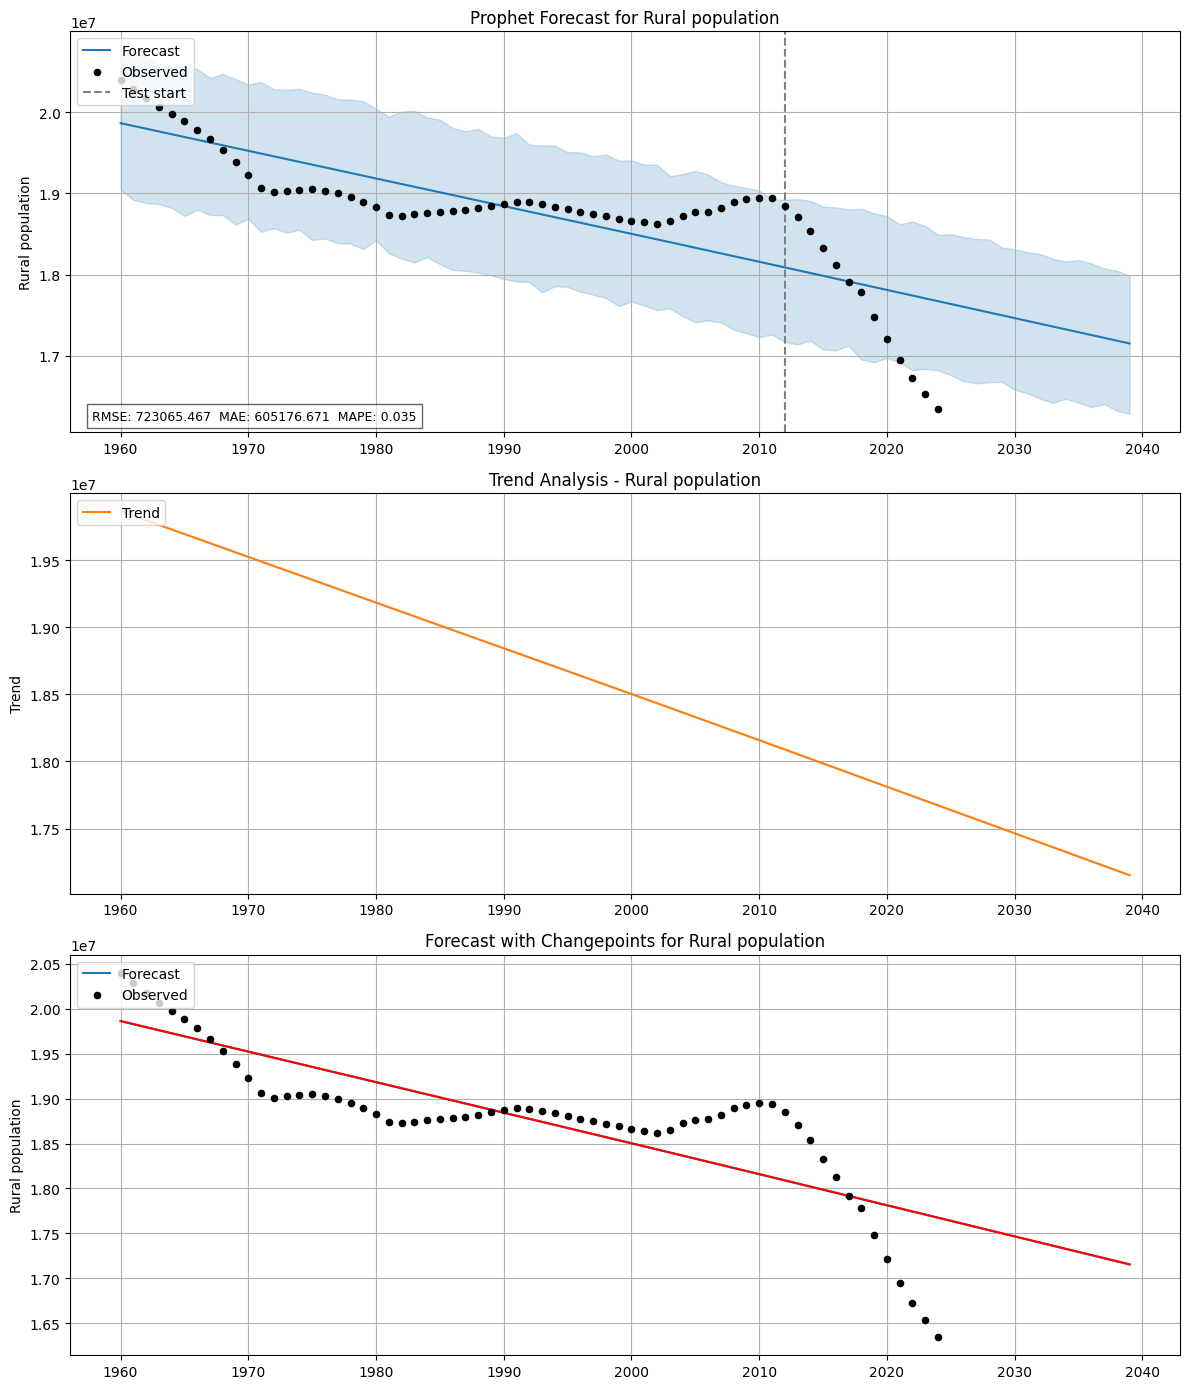



------------------------------EMPLOYMENT IN AGRICULTURE (% OF TOTAL EMPLOYMENT)------------------------------
Serie con 33 punti. Parametri CV impostati a:
Initial: 23 anni, Horizon: 6 anni, Period: 3 anni
PARAMETRI MIGLIORI TROVATI: {'growth': 'linear', 'changepoint_prior_scale': 0.5}
Creazione previsioni per 15 periodi futuri
Validation metrics (test) for Employment in agriculture (% of total employment): {'mse': np.float64(0.019659671890160053), 'rmse': np.float64(0.14021295193440603), 'mae': np.float64(0.11846078527746055), 'mape': np.float64(0.03086563415248639)}


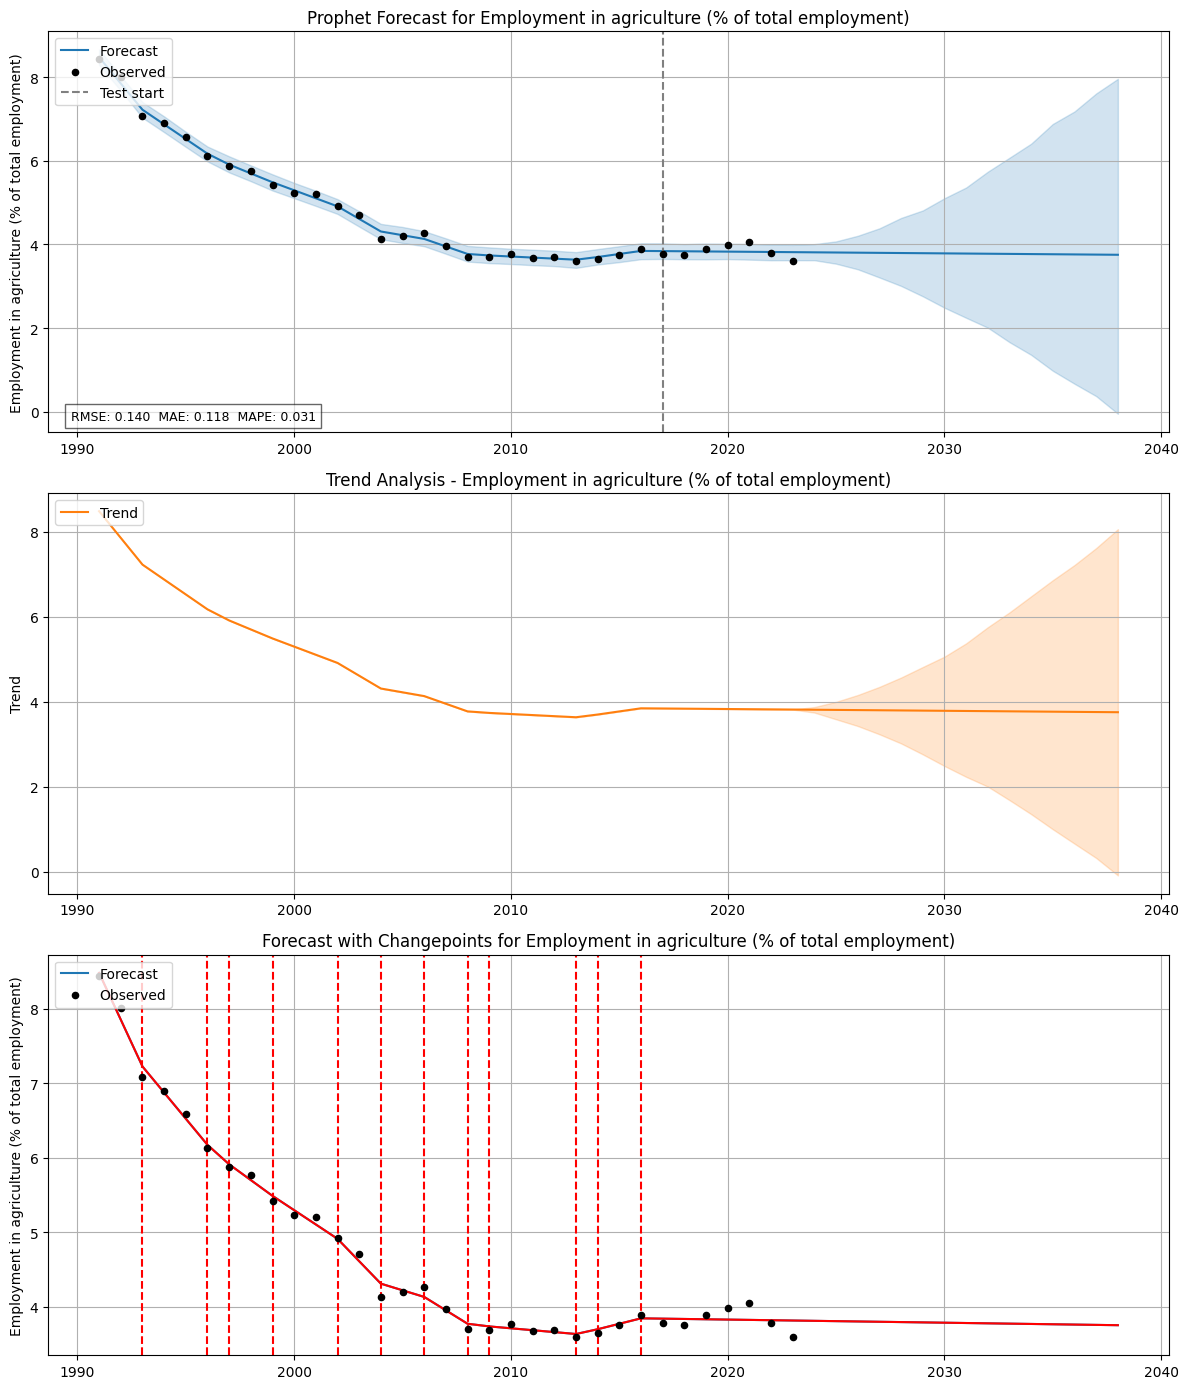



------------------------------EMPLOYMENT IN AGRICULTURE, MALE (% OF MALE EMPLOYMENT)------------------------------
Serie con 33 punti. Parametri CV impostati a:
Initial: 23 anni, Horizon: 6 anni, Period: 3 anni
PARAMETRI MIGLIORI TROVATI: {'growth': 'linear', 'changepoint_prior_scale': 0.5}
Creazione previsioni per 15 periodi futuri
Validation metrics (test) for Employment in agriculture, male (% of male employment): {'mse': np.float64(0.036301600233656584), 'rmse': np.float64(0.19052978831053316), 'mae': np.float64(0.16439733763716383), 'mape': np.float64(0.03343716938250317)}


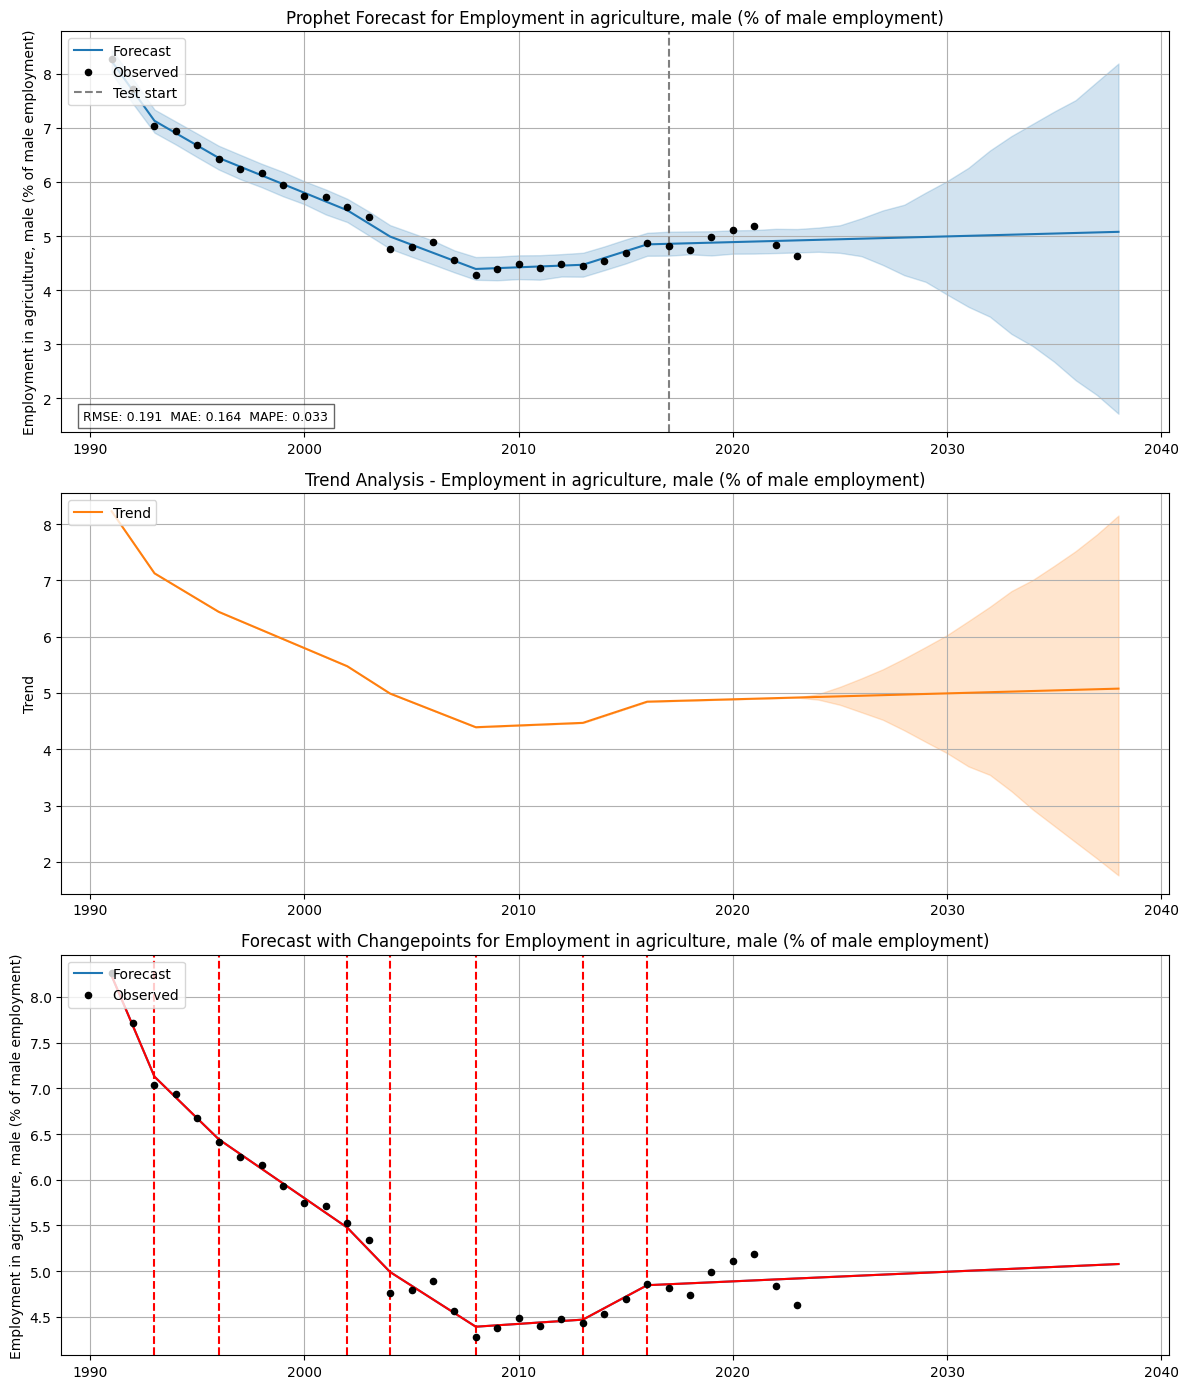



------------------------------EMPLOYMENT IN AGRICULTURE, FEMALE (% OF FEMALE EMPLOYMENT)------------------------------
Serie con 33 punti. Parametri CV impostati a:
Initial: 23 anni, Horizon: 6 anni, Period: 3 anni
PARAMETRI MIGLIORI TROVATI: {'growth': 'linear', 'changepoint_prior_scale': 0.5}
Creazione previsioni per 15 periodi futuri
Validation metrics (test) for Employment in agriculture, female (% of female employment): {'mse': np.float64(0.005630425277378601), 'rmse': np.float64(0.07503615979898359), 'mae': np.float64(0.06010744886936058), 'mape': np.float64(0.02562755900398402)}


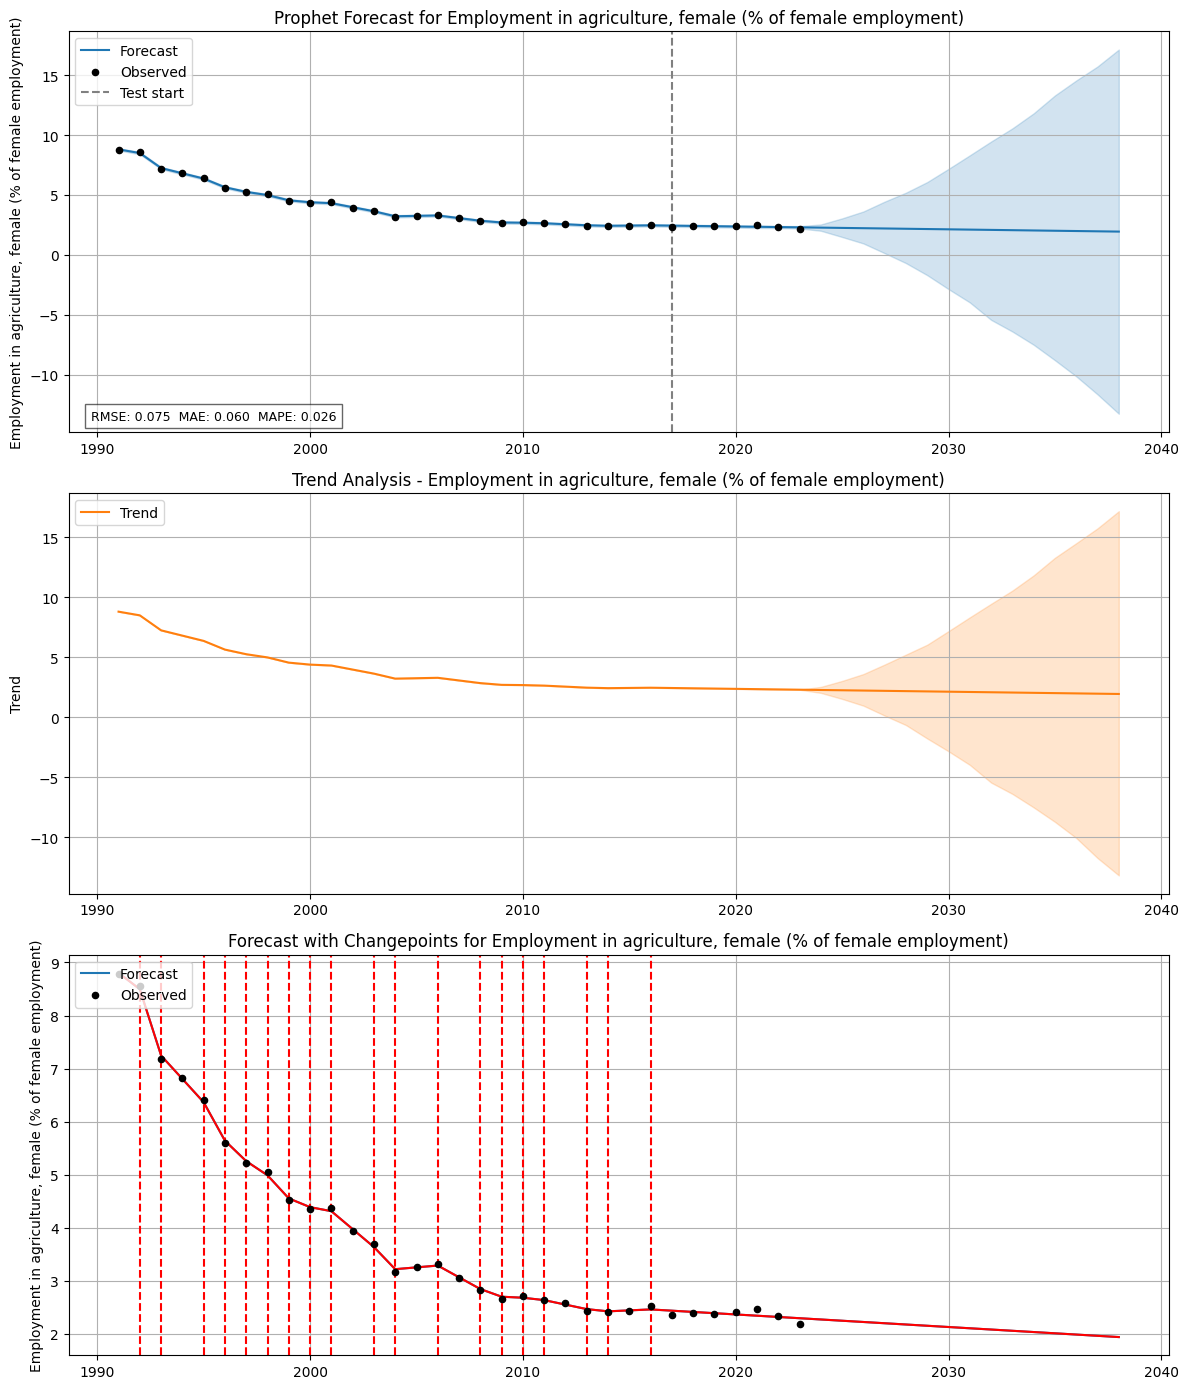



------------------------------FOREST AREA (% OF LAND AREA)------------------------------
Serie con 33 punti. Parametri CV impostati a:
Initial: 23 anni, Horizon: 6 anni, Period: 3 anni
PARAMETRI MIGLIORI TROVATI: {'growth': 'linear', 'changepoint_prior_scale': 0.5}
Creazione previsioni per 15 periodi futuri
Validation metrics (test) for Forest area (% of land area): {'mse': np.float64(3.611937707403917e-08), 'rmse': np.float64(0.00019005098545926872), 'mae': np.float64(0.0001666654788868373), 'mape': np.float64(5.1790579279060886e-06)}


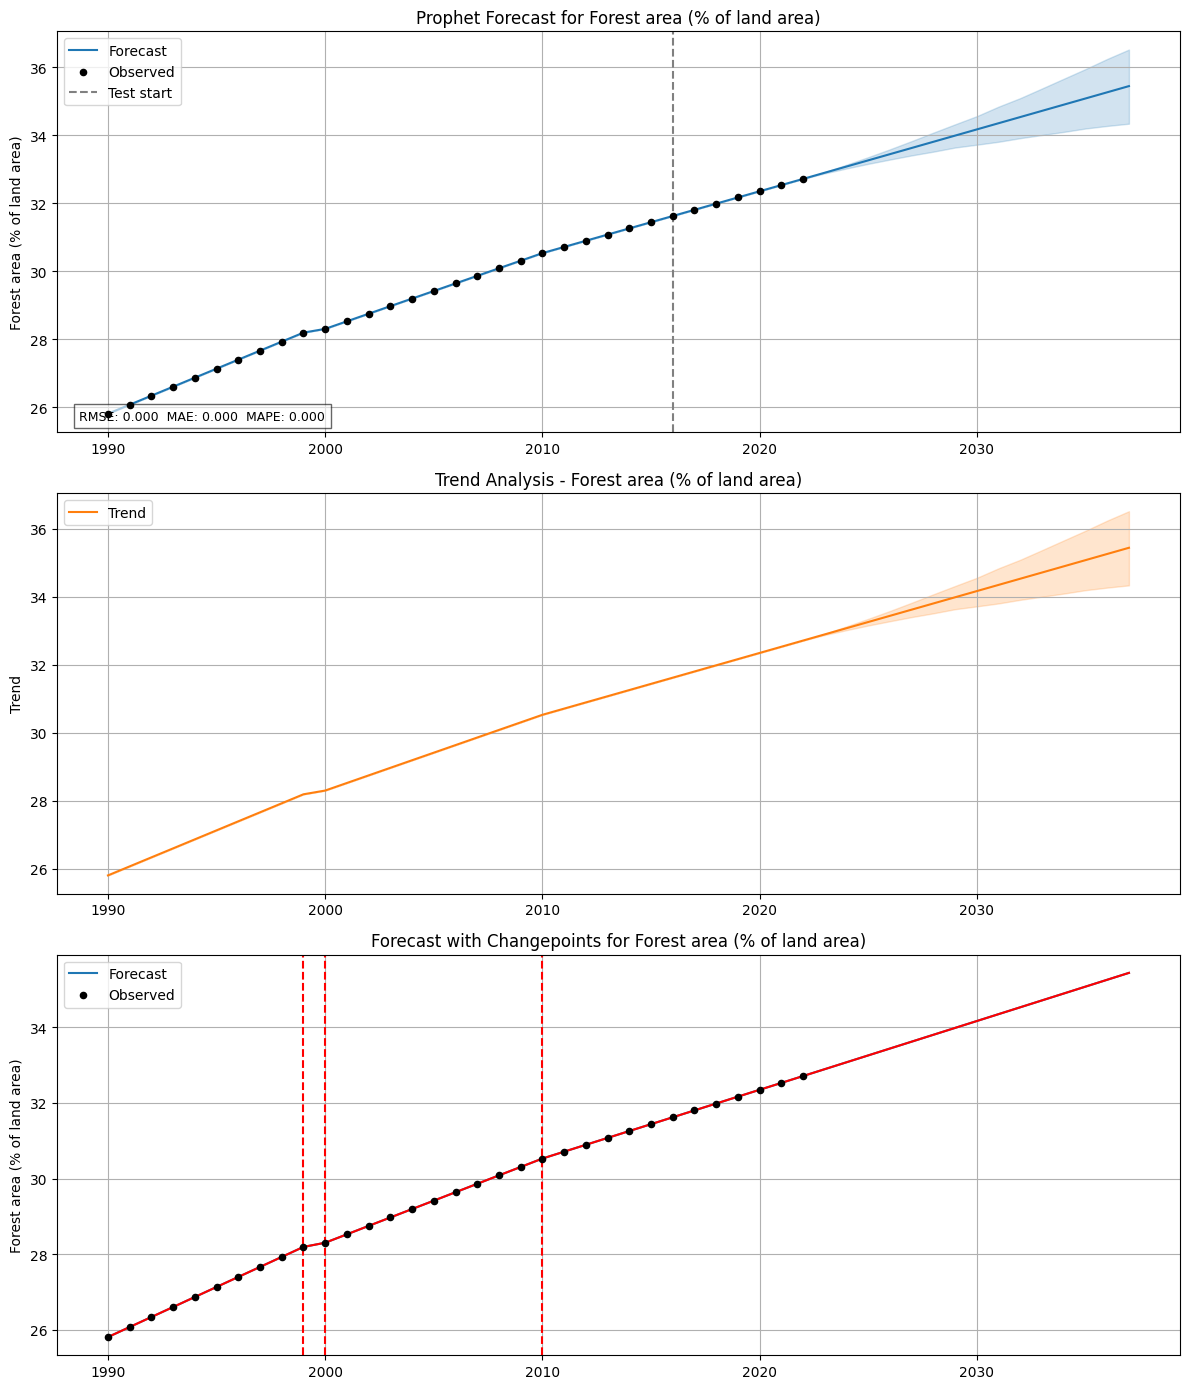



------------------------------FOREST AREA (SQ. KM)------------------------------
Serie con 33 punti. Parametri CV impostati a:
Initial: 23 anni, Horizon: 6 anni, Period: 3 anni
PARAMETRI MIGLIORI TROVATI: {'growth': 'linear', 'changepoint_prior_scale': 0.5}
Creazione previsioni per 15 periodi futuri
Validation metrics (test) for Forest area (sq. km): {'mse': np.float64(0.17714319187055375), 'rmse': np.float64(0.42088382229607463), 'mae': np.float64(0.36077474427293055), 'mape': np.float64(3.803861066647344e-06)}


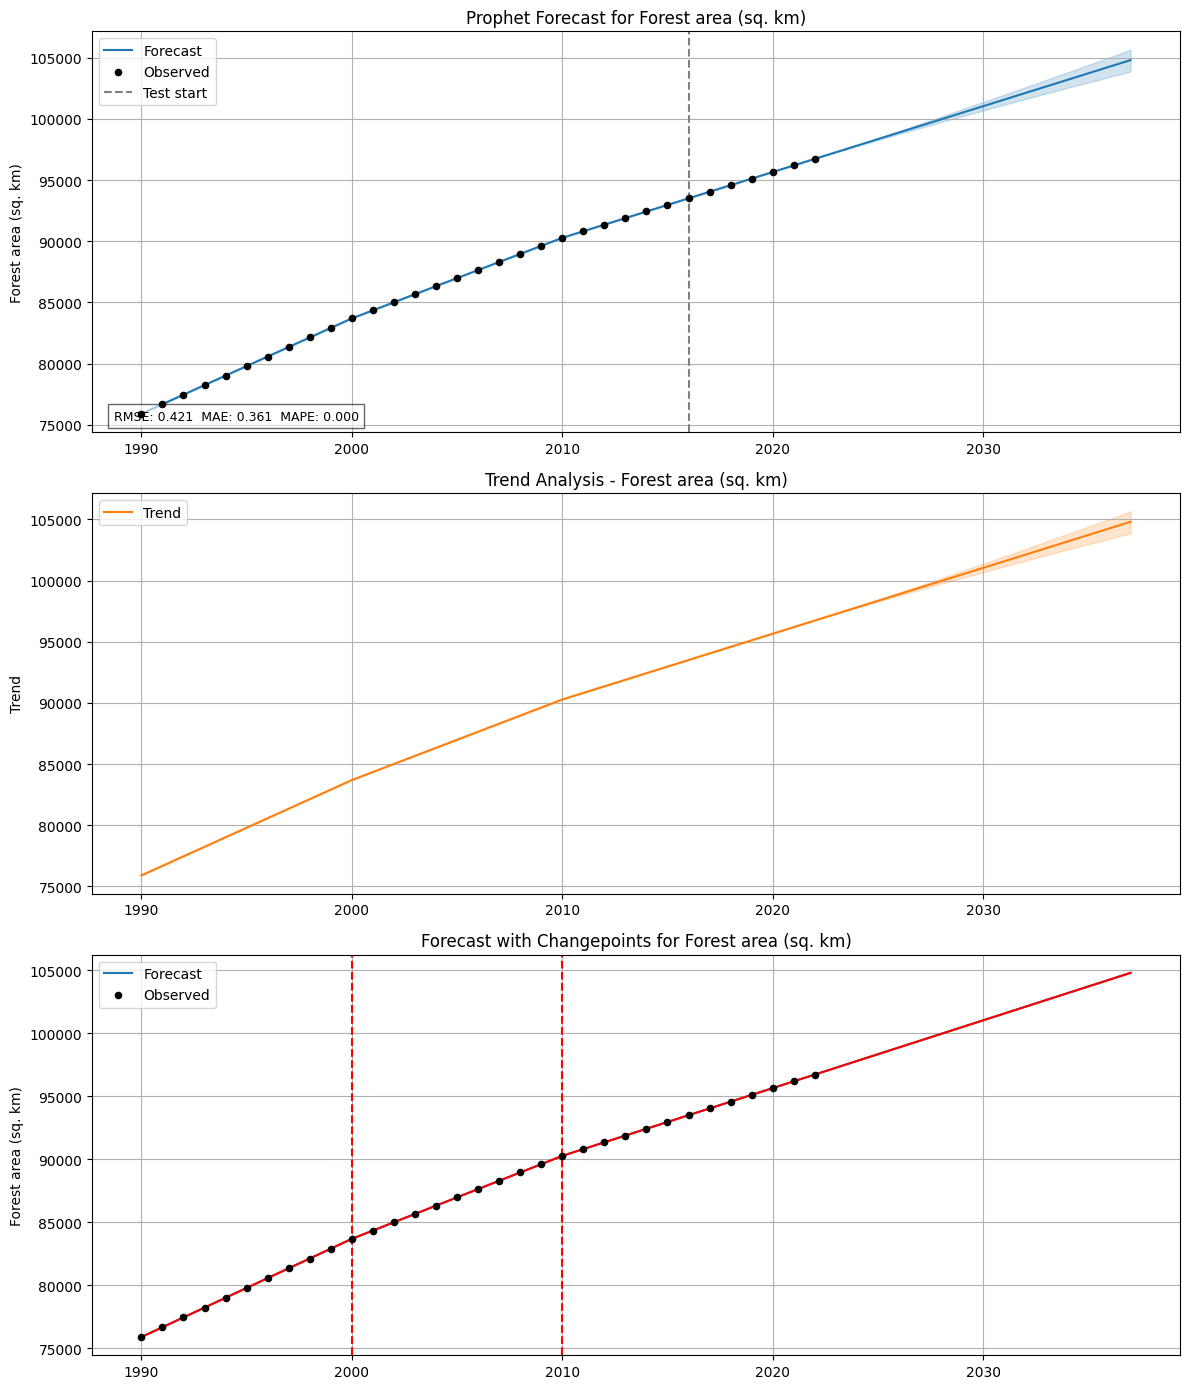



------------------------------AGRICULTURAL LAND (% OF LAND AREA)------------------------------
Serie con 62 punti. Parametri CV impostati a:
Initial: 43 anni, Horizon: 12 anni, Period: 6 anni
PARAMETRI MIGLIORI TROVATI: {'growth': 'linear', 'changepoint_prior_scale': 0.1}
Creazione previsioni per 15 periodi futuri
Validation metrics (test) for Agricultural land (% of land area): {'mse': np.float64(1.1388749577889141), 'rmse': np.float64(1.0671808458686438), 'mae': np.float64(0.8701561165448481), 'mape': np.float64(0.019759256140977493)}


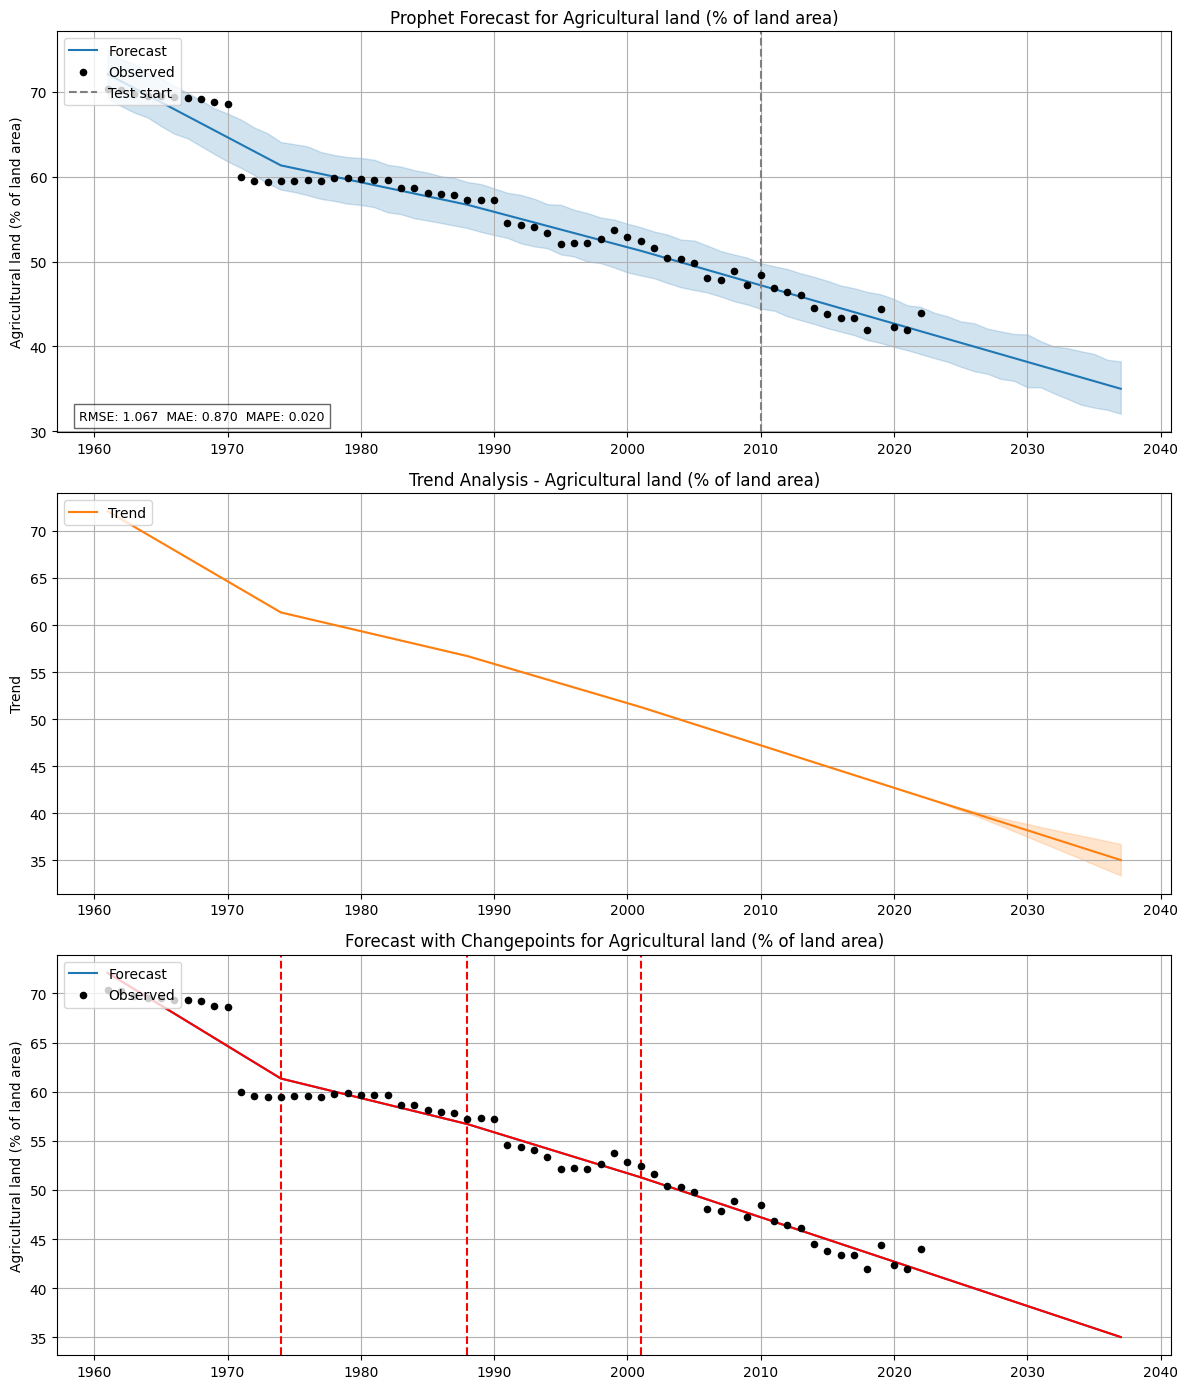



------------------------------AGRICULTURAL LAND (SQ. KM)------------------------------
Serie con 61 punti. Parametri CV impostati a:
Initial: 42 anni, Horizon: 12 anni, Period: 6 anni
PARAMETRI MIGLIORI TROVATI: {'growth': 'linear', 'changepoint_prior_scale': 0.05}
Creazione previsioni per 15 periodi futuri
Validation metrics (test) for Agricultural land (sq. km): {'mse': np.float64(6487266.85924847), 'rmse': np.float64(2547.011358288076), 'mae': np.float64(2109.2010974556), 'mape': np.float64(0.016069375358407266)}


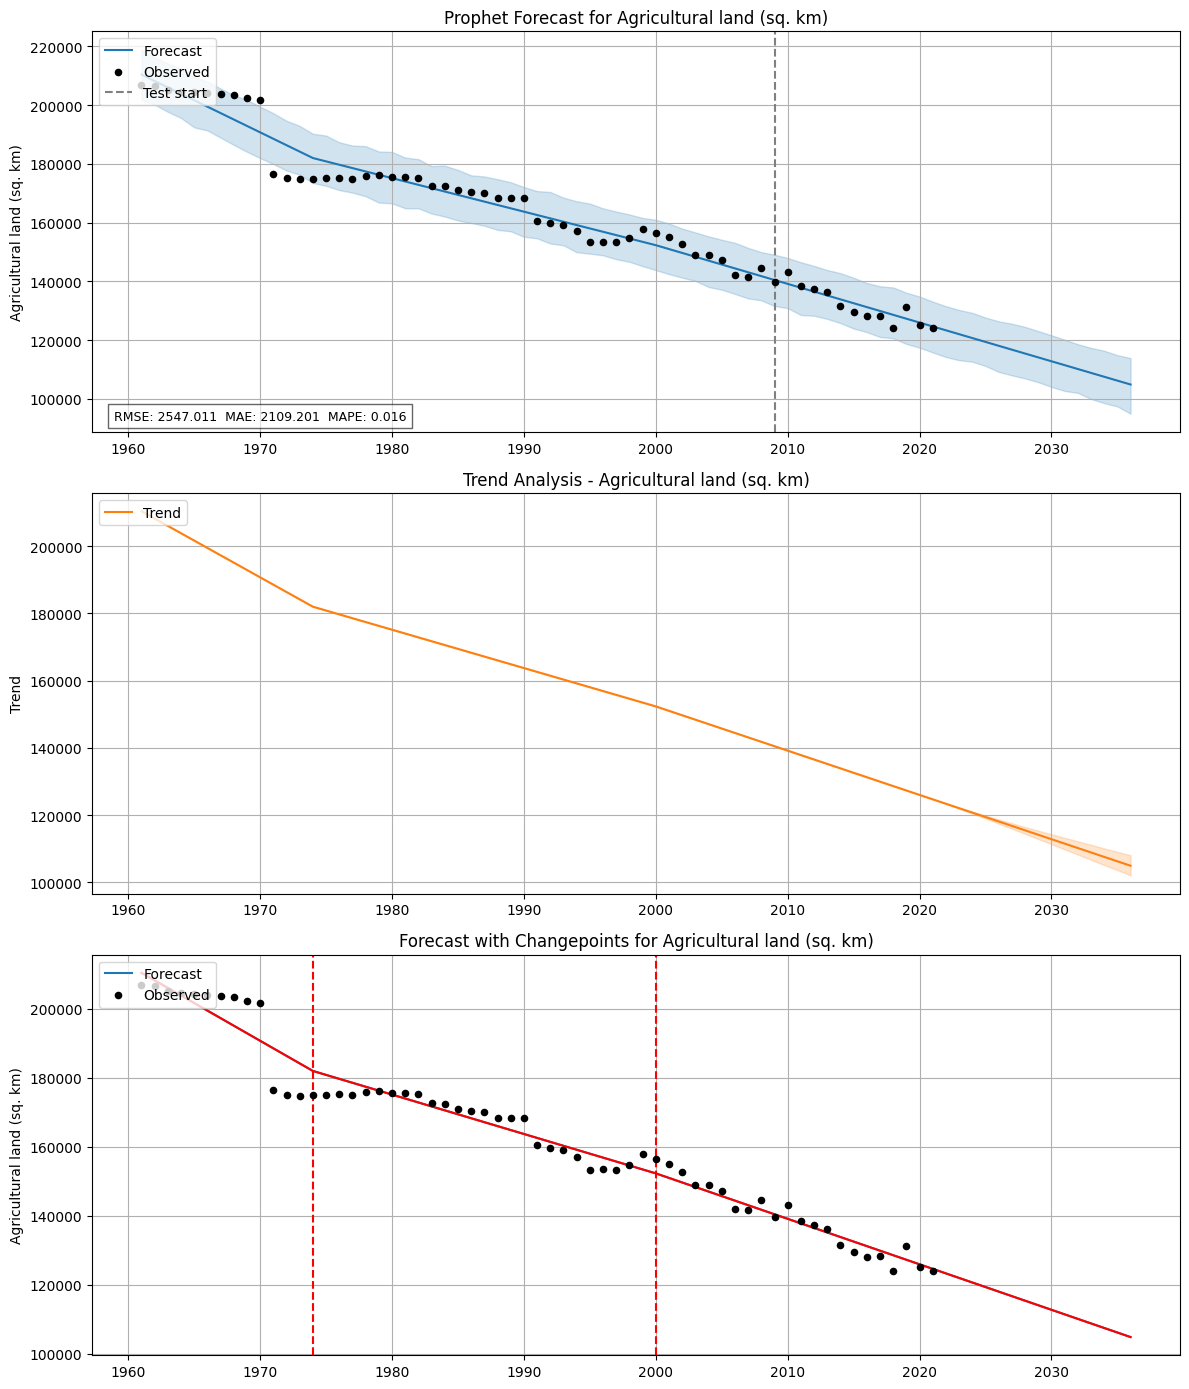



------------------------------ARABLE LAND (% OF LAND AREA)------------------------------
Serie con 62 punti. Parametri CV impostati a:
Initial: 43 anni, Horizon: 12 anni, Period: 6 anni
PARAMETRI MIGLIORI TROVATI: {'growth': 'linear', 'changepoint_prior_scale': 0.5}
Creazione previsioni per 15 periodi futuri
Validation metrics (test) for Arable land (% of land area): {'mse': np.float64(0.4773144240088515), 'rmse': np.float64(0.6908794569306946), 'mae': np.float64(0.638590483381443), 'mape': np.float64(0.027454519259699987)}


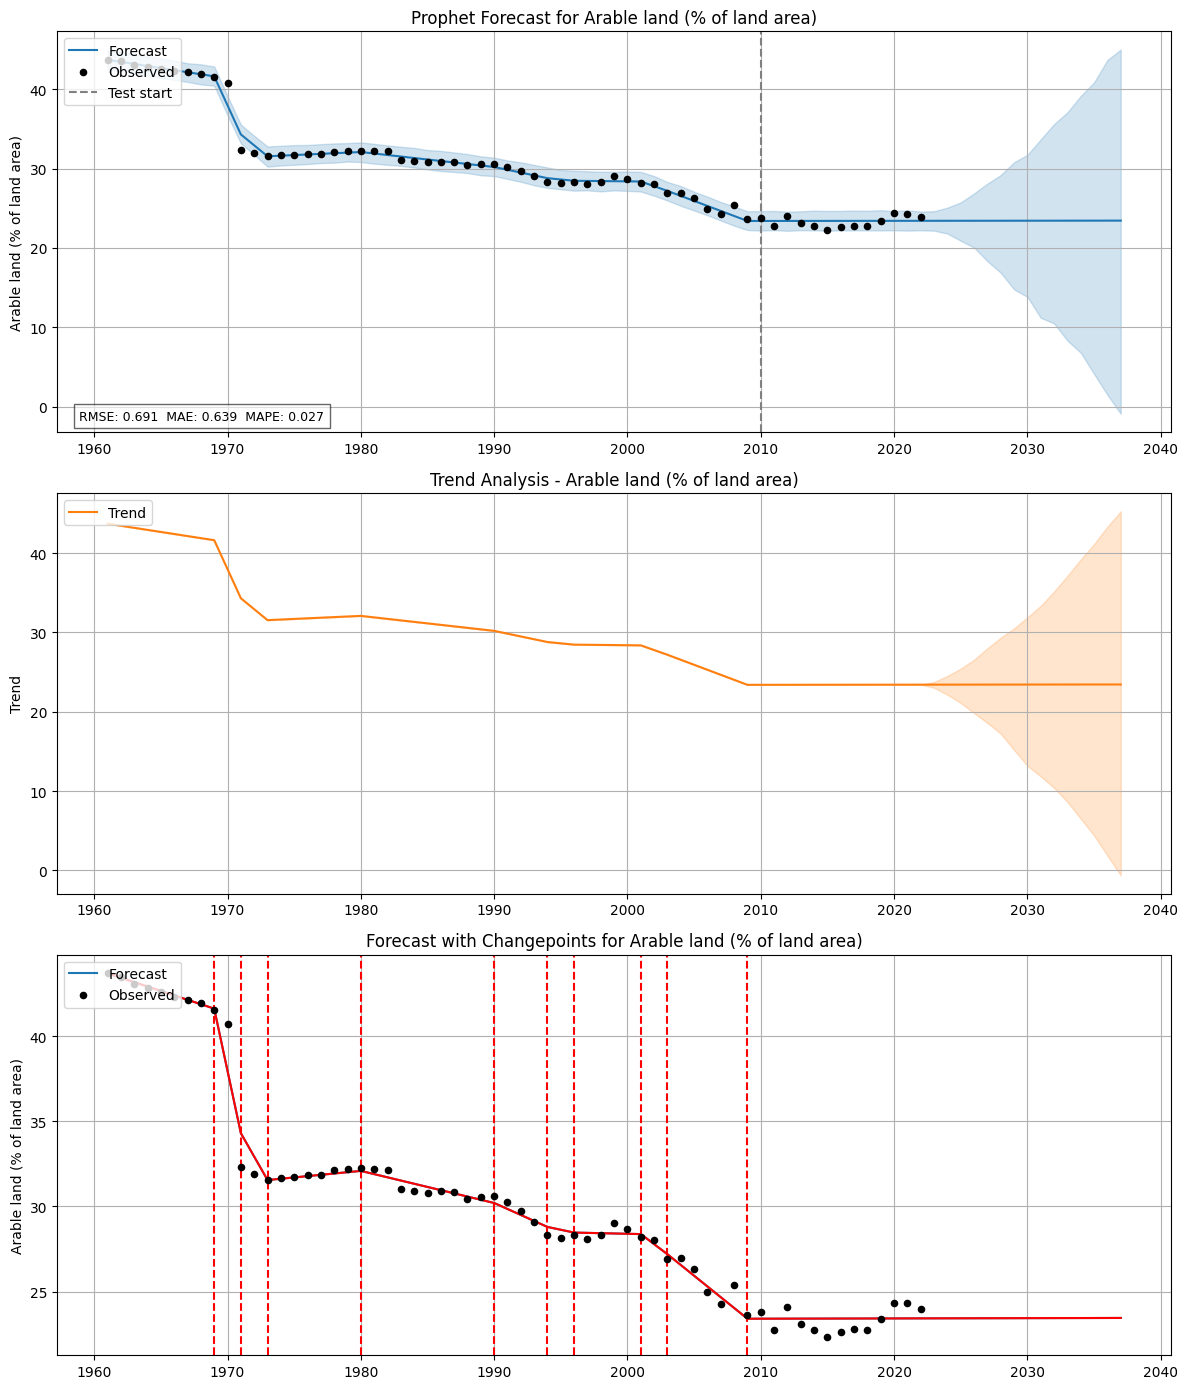



------------------------------ARABLE LAND (HECTARES PER PERSON)------------------------------
Serie con 61 punti. Parametri CV impostati a:
Initial: 42 anni, Horizon: 12 anni, Period: 6 anni
PARAMETRI MIGLIORI TROVATI: {'growth': 'linear', 'changepoint_prior_scale': 0.5}
Creazione previsioni per 15 periodi futuri
Validation metrics (test) for Arable land (hectares per person): {'mse': np.float64(1.829380392830131e-05), 'rmse': np.float64(0.004277125661972221), 'mae': np.float64(0.0036196144157567864), 'mape': np.float64(0.03154666664962371)}


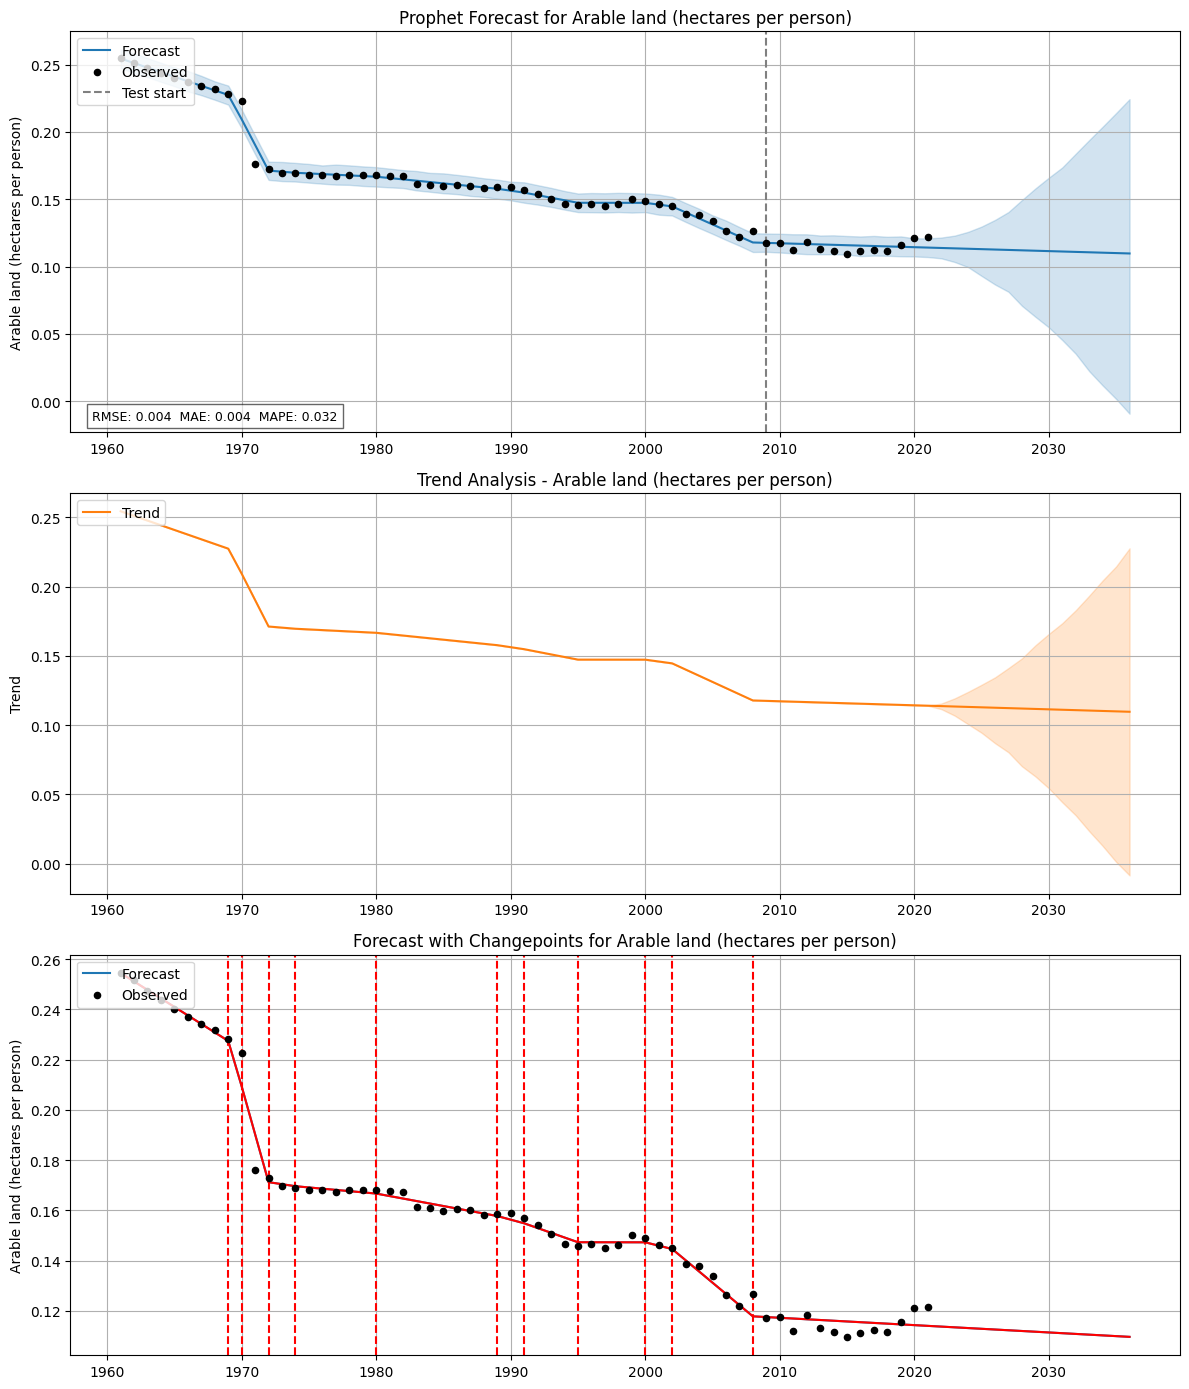



------------------------------ARABLE LAND (HECTARES)------------------------------
Serie con 61 punti. Parametri CV impostati a:
Initial: 42 anni, Horizon: 12 anni, Period: 6 anni
PARAMETRI MIGLIORI TROVATI: {'growth': 'linear', 'changepoint_prior_scale': 0.5}
Creazione previsioni per 15 periodi futuri
Validation metrics (test) for Arable land (hectares): {'mse': np.float64(47761327612.9893), 'rmse': np.float64(218543.65150465776), 'mae': np.float64(189232.937988872), 'mape': np.float64(0.02751826387220391)}


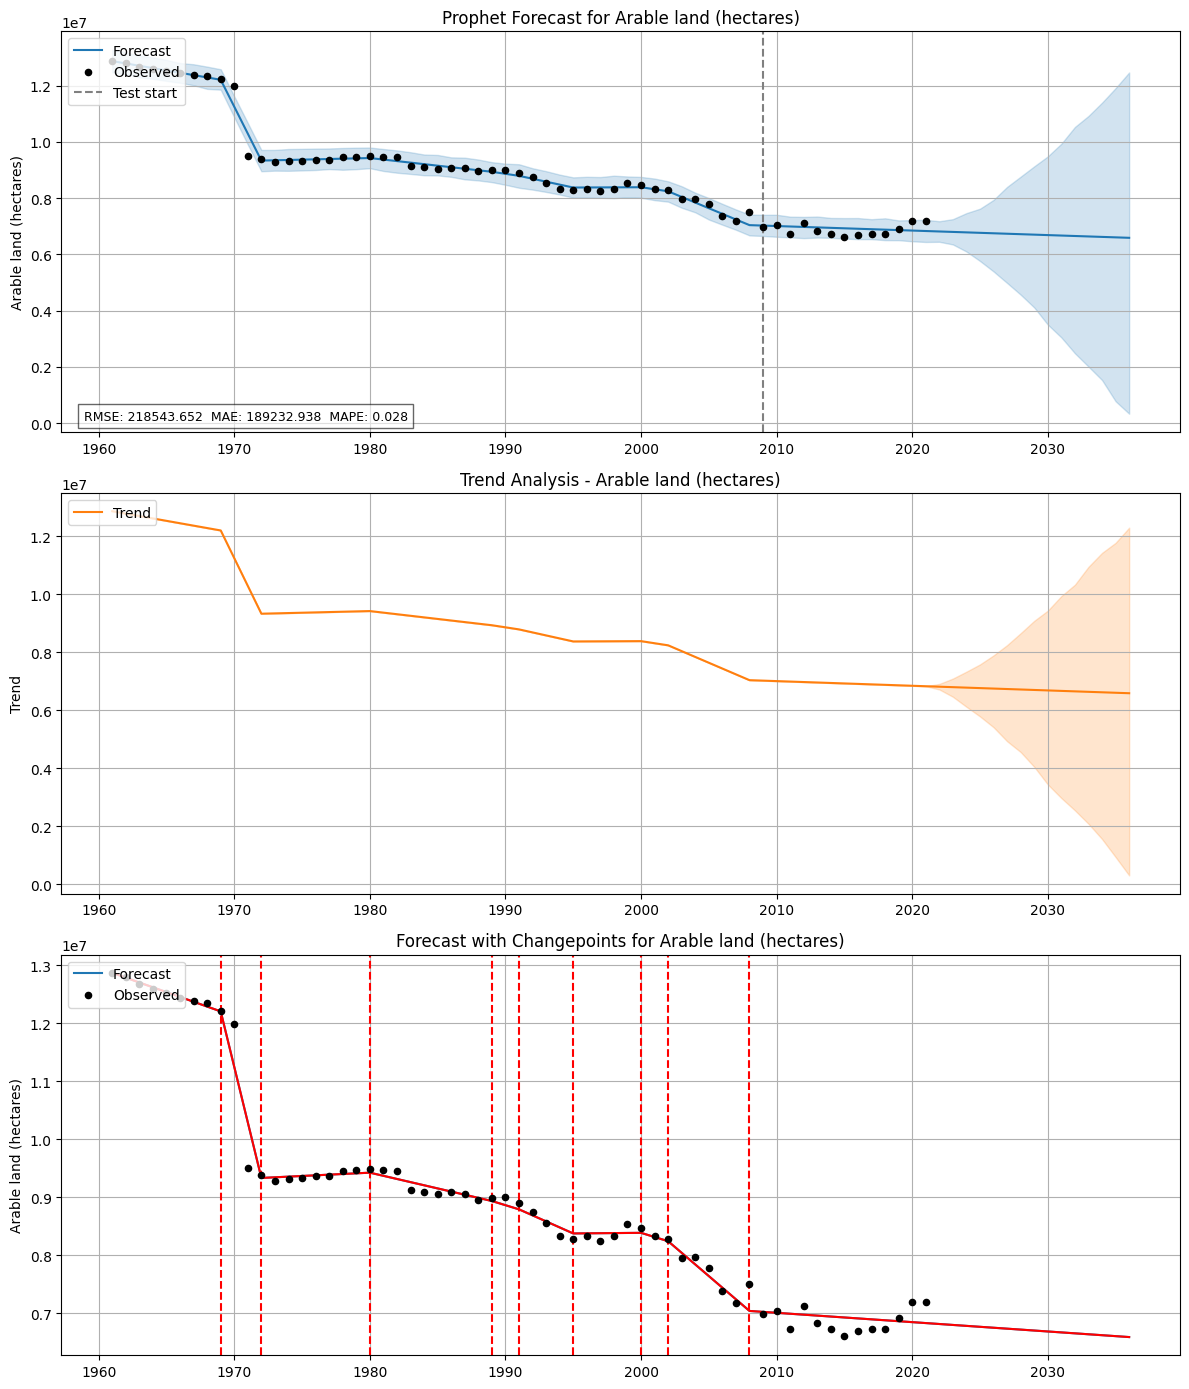



------------------------------LAND UNDER CEREAL PRODUCTION (HECTARES)------------------------------
Serie con 62 punti. Parametri CV impostati a:
Initial: 43 anni, Horizon: 12 anni, Period: 6 anni
PARAMETRI MIGLIORI TROVATI: {'growth': 'linear', 'changepoint_prior_scale': 0.05}
Creazione previsioni per 15 periodi futuri
Validation metrics (test) for Land under cereal production (hectares): {'mse': np.float64(4273862056.8428125), 'rmse': np.float64(65374.78150512484), 'mae': np.float64(56384.67017330702), 'mape': np.float64(0.017535802874492638)}


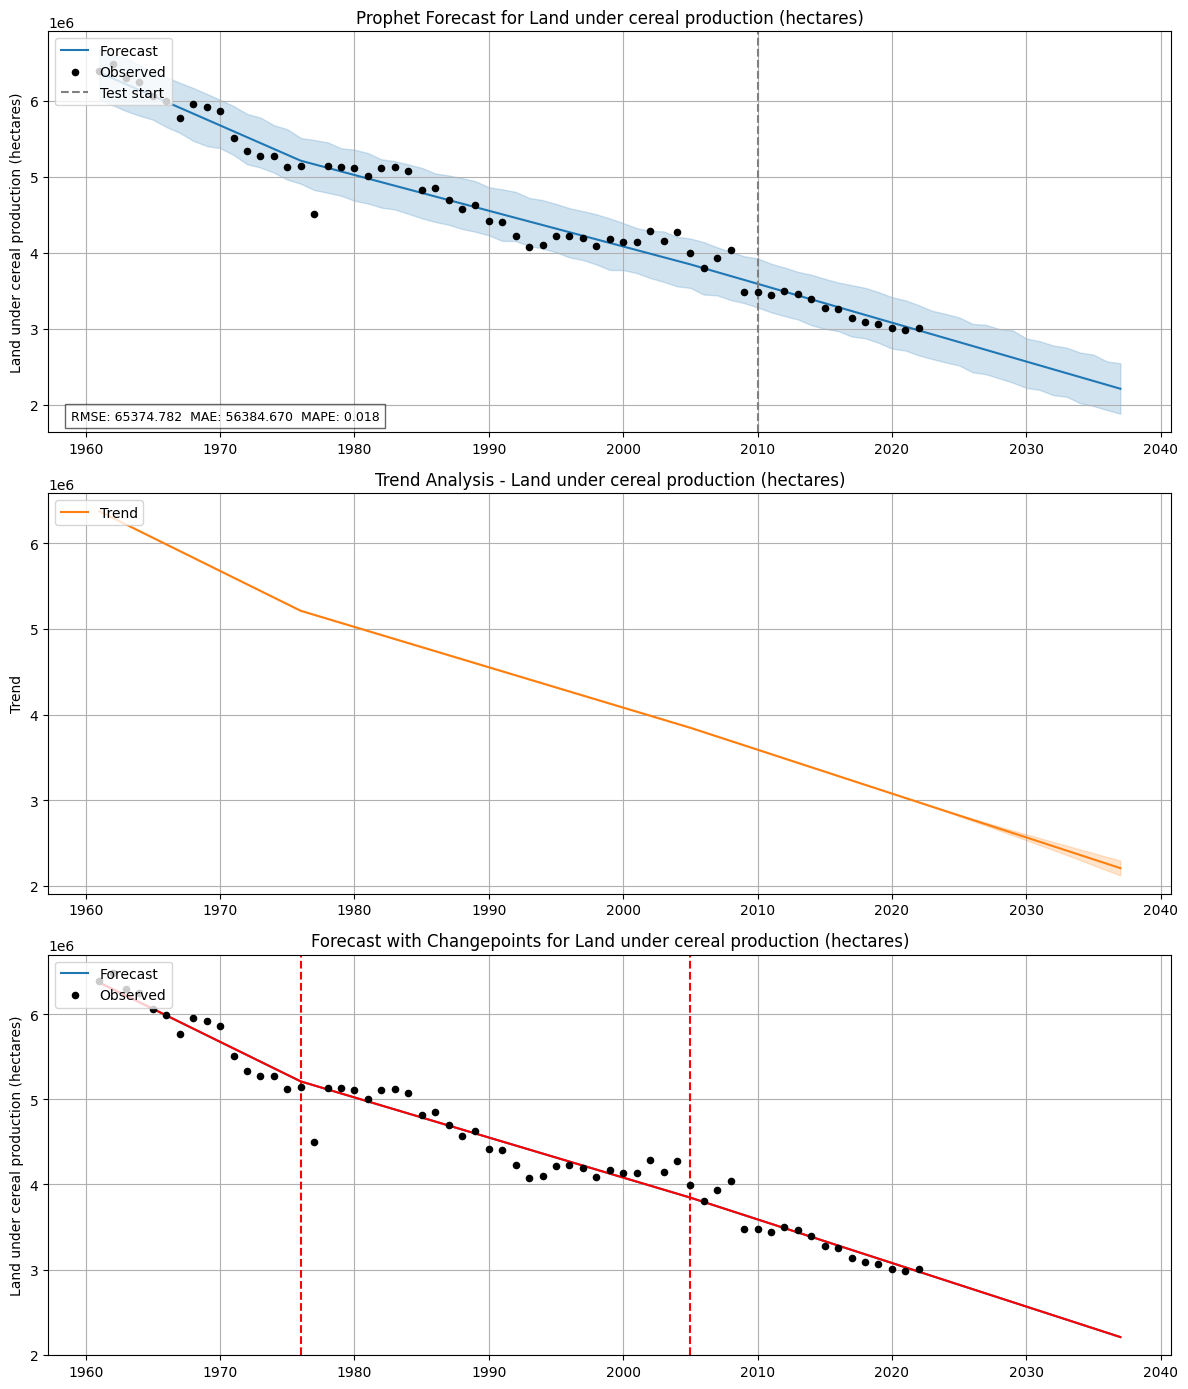



------------------------------PERMANENT CROPLAND (% OF LAND AREA)------------------------------
Serie con 62 punti. Parametri CV impostati a:
Initial: 43 anni, Horizon: 12 anni, Period: 6 anni
PARAMETRI MIGLIORI TROVATI: {'growth': 'linear', 'changepoint_prior_scale': 0.1}
Creazione previsioni per 15 periodi futuri
Validation metrics (test) for Permanent cropland (% of land area): {'mse': np.float64(0.10638398826641933), 'rmse': np.float64(0.3261655841231863), 'mae': np.float64(0.2860745443186972), 'mape': np.float64(0.03602208384734147)}


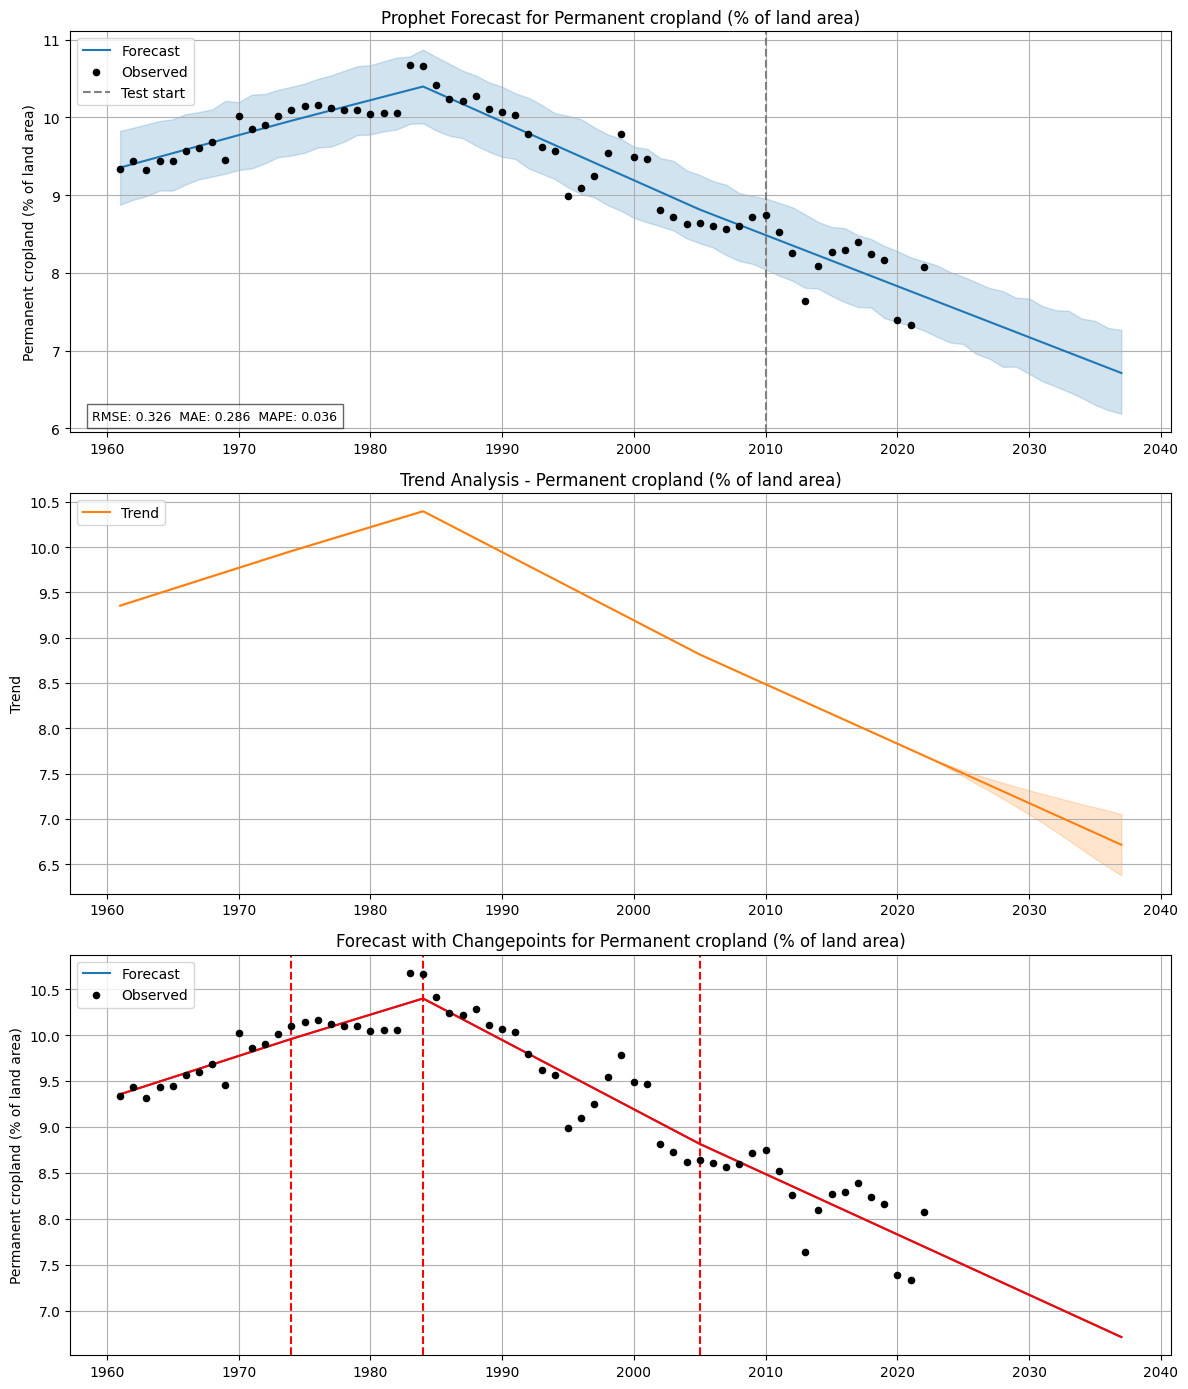



------------------------------ANNUAL FRESHWATER WITHDRAWALS, AGRICULTURE (% OF TOTAL FRESHWATER WITHDRAWAL)------------------------------
Serie con 52 punti. Parametri CV impostati a:
Initial: 36 anni, Horizon: 10 anni, Period: 5 anni
PARAMETRI MIGLIORI TROVATI: {'growth': 'linear', 'changepoint_prior_scale': 0.5}
Creazione previsioni per 15 periodi futuri
Validation metrics (test) for Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal): {'mse': np.float64(1.6675996908698991), 'rmse': np.float64(1.2913557568965646), 'mae': np.float64(1.0676112449476471), 'mape': np.float64(0.021512724602822234)}


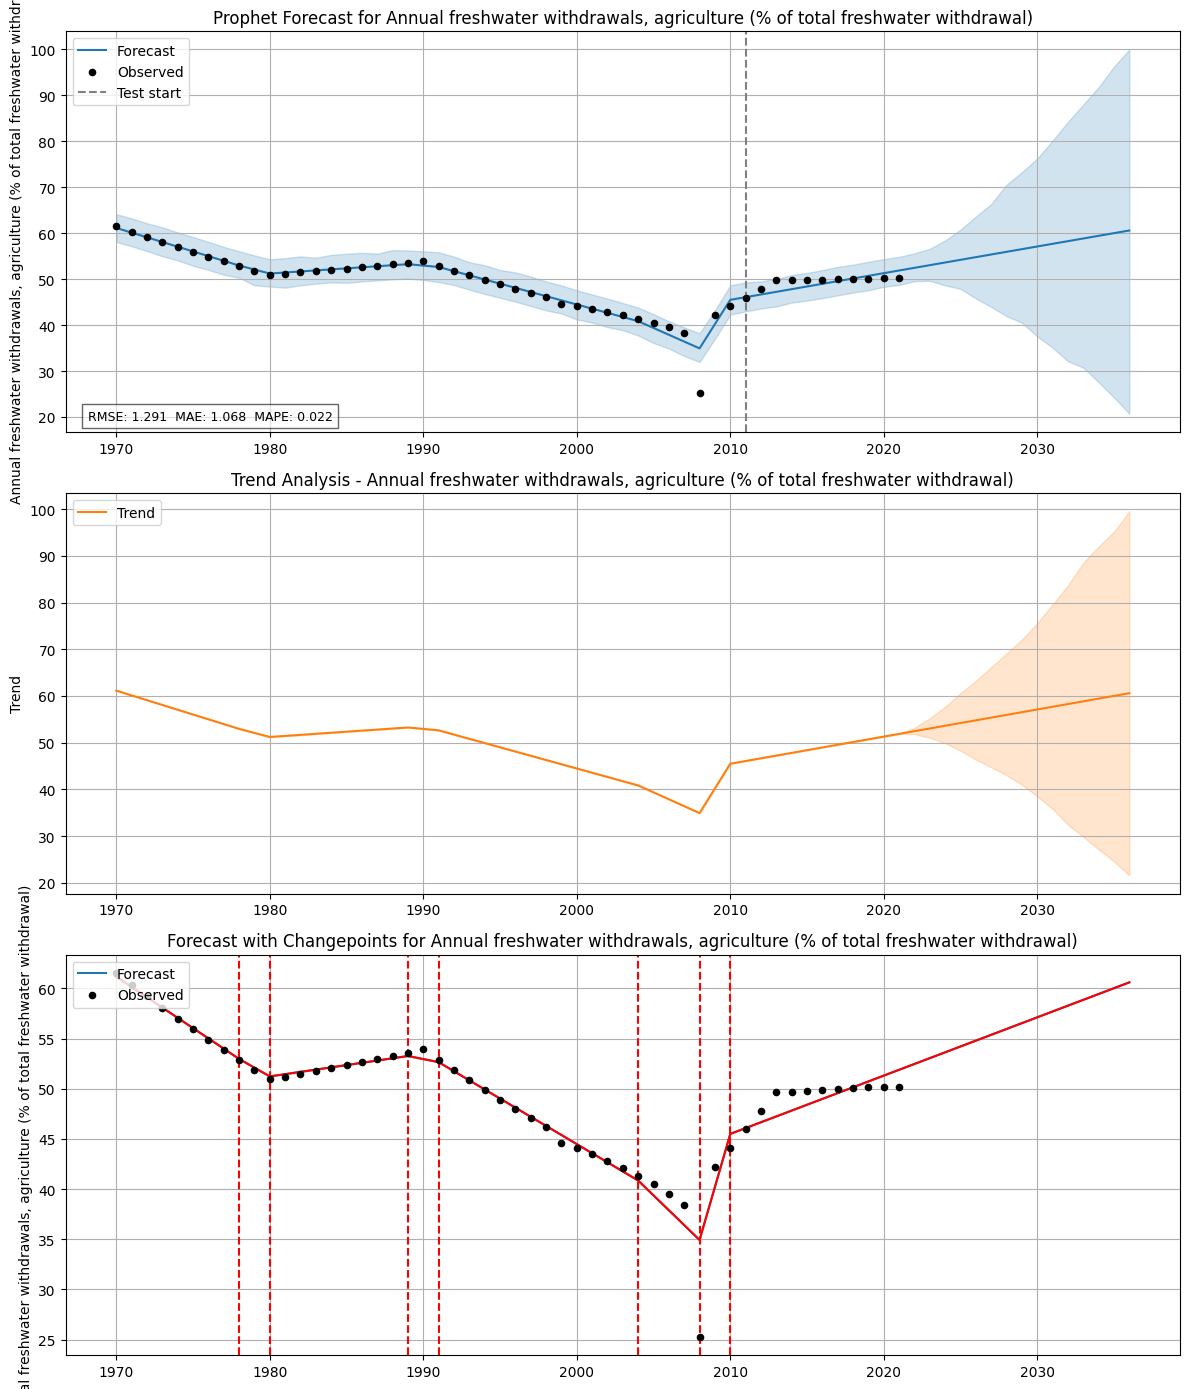



------------------------------FERTILIZER CONSUMPTION (KILOGRAMS PER HECTARE OF ARABLE LAND)------------------------------
Serie con 62 punti. Parametri CV impostati a:
Initial: 43 anni, Horizon: 12 anni, Period: 6 anni
PARAMETRI MIGLIORI TROVATI: {'growth': 'linear', 'changepoint_prior_scale': 0.5}
Creazione previsioni per 15 periodi futuri
Validation metrics (test) for Fertilizer consumption (kilograms per hectare of arable land): {'mse': np.float64(70.87644608422686), 'rmse': np.float64(8.418815004751373), 'mae': np.float64(6.8994879930224515), 'mape': np.float64(0.05483800314114276)}


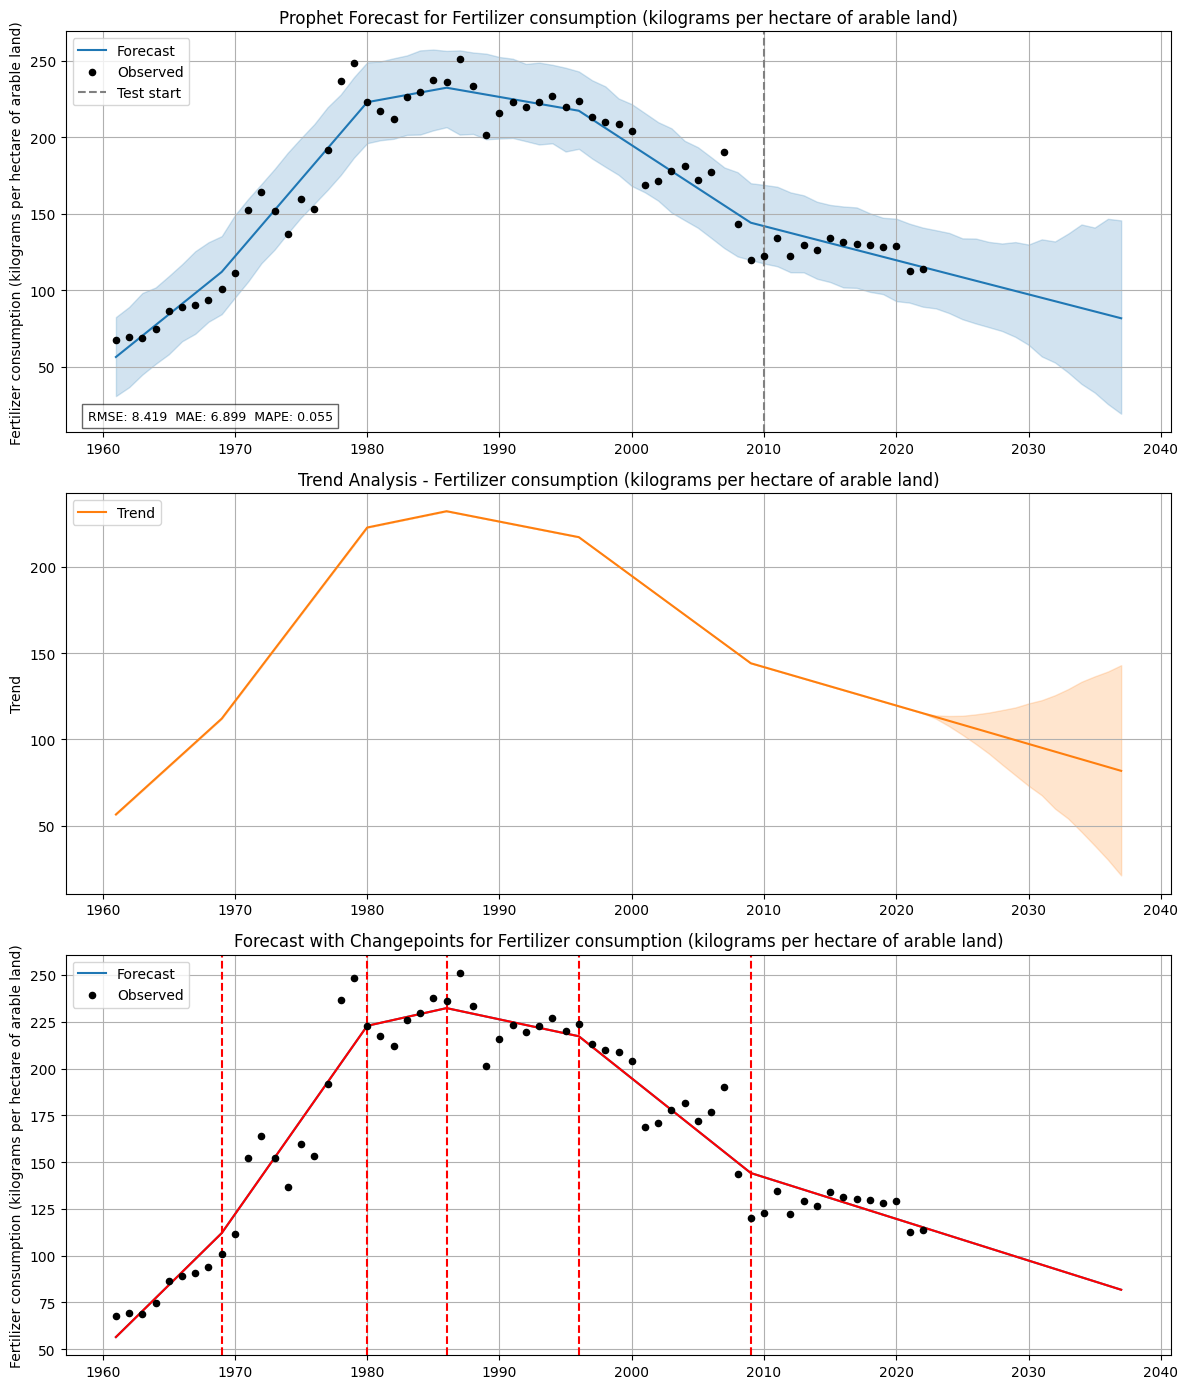



------------------------------FERTILIZER CONSUMPTION (% OF FERTILIZER PRODUCTION)------------------------------
Serie con 62 punti. Parametri CV impostati a:
Initial: 43 anni, Horizon: 12 anni, Period: 6 anni
PARAMETRI MIGLIORI TROVATI: {'growth': 'linear', 'changepoint_prior_scale': 0.1}
Creazione previsioni per 15 periodi futuri
Validation metrics (test) for Fertilizer consumption (% of fertilizer production): {'mse': np.float64(4241.652013162685), 'rmse': np.float64(65.12796644424486), 'mae': np.float64(54.8402541829026), 'mape': np.float64(0.3773879628187173)}


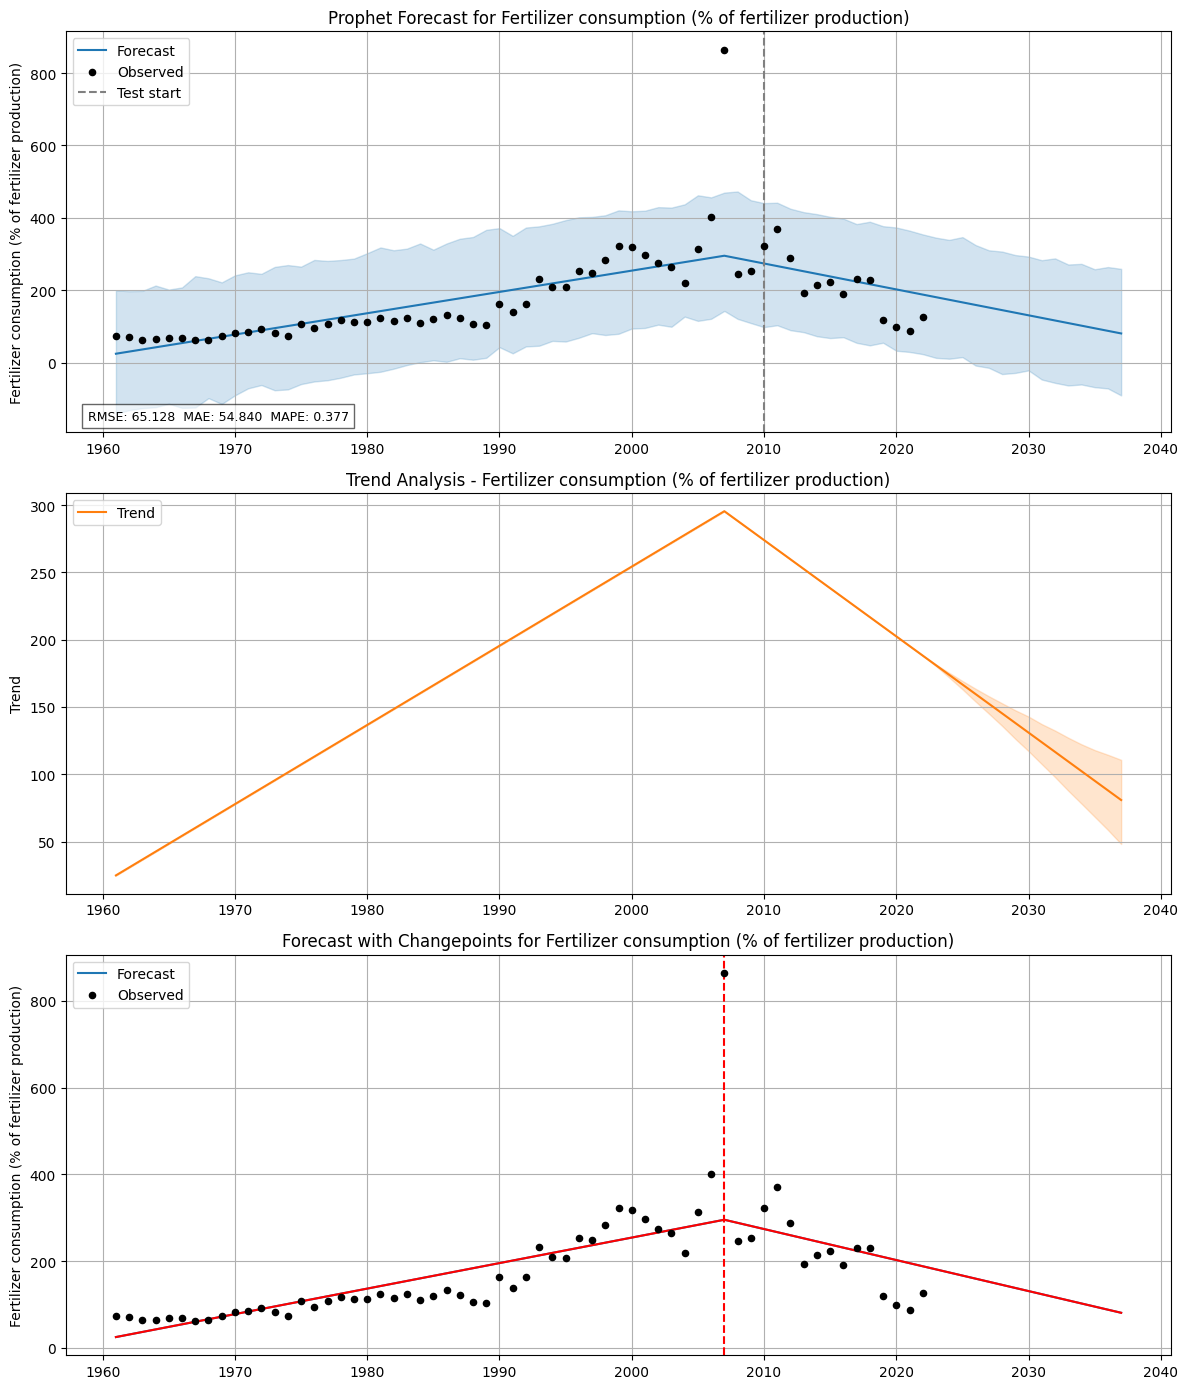



------------------------------LIVESTOCK PRODUCTION INDEX (2014-2016 = 100)------------------------------
Serie con 62 punti. Parametri CV impostati a:
Initial: 43 anni, Horizon: 12 anni, Period: 6 anni
PARAMETRI MIGLIORI TROVATI: {'growth': 'linear', 'changepoint_prior_scale': 0.5}
Creazione previsioni per 15 periodi futuri
Validation metrics (test) for Livestock production index (2014-2016 = 100): {'mse': np.float64(14.962130731886136), 'rmse': np.float64(3.868091355162923), 'mae': np.float64(3.0823129403128693), 'mape': np.float64(0.030096033234801995)}


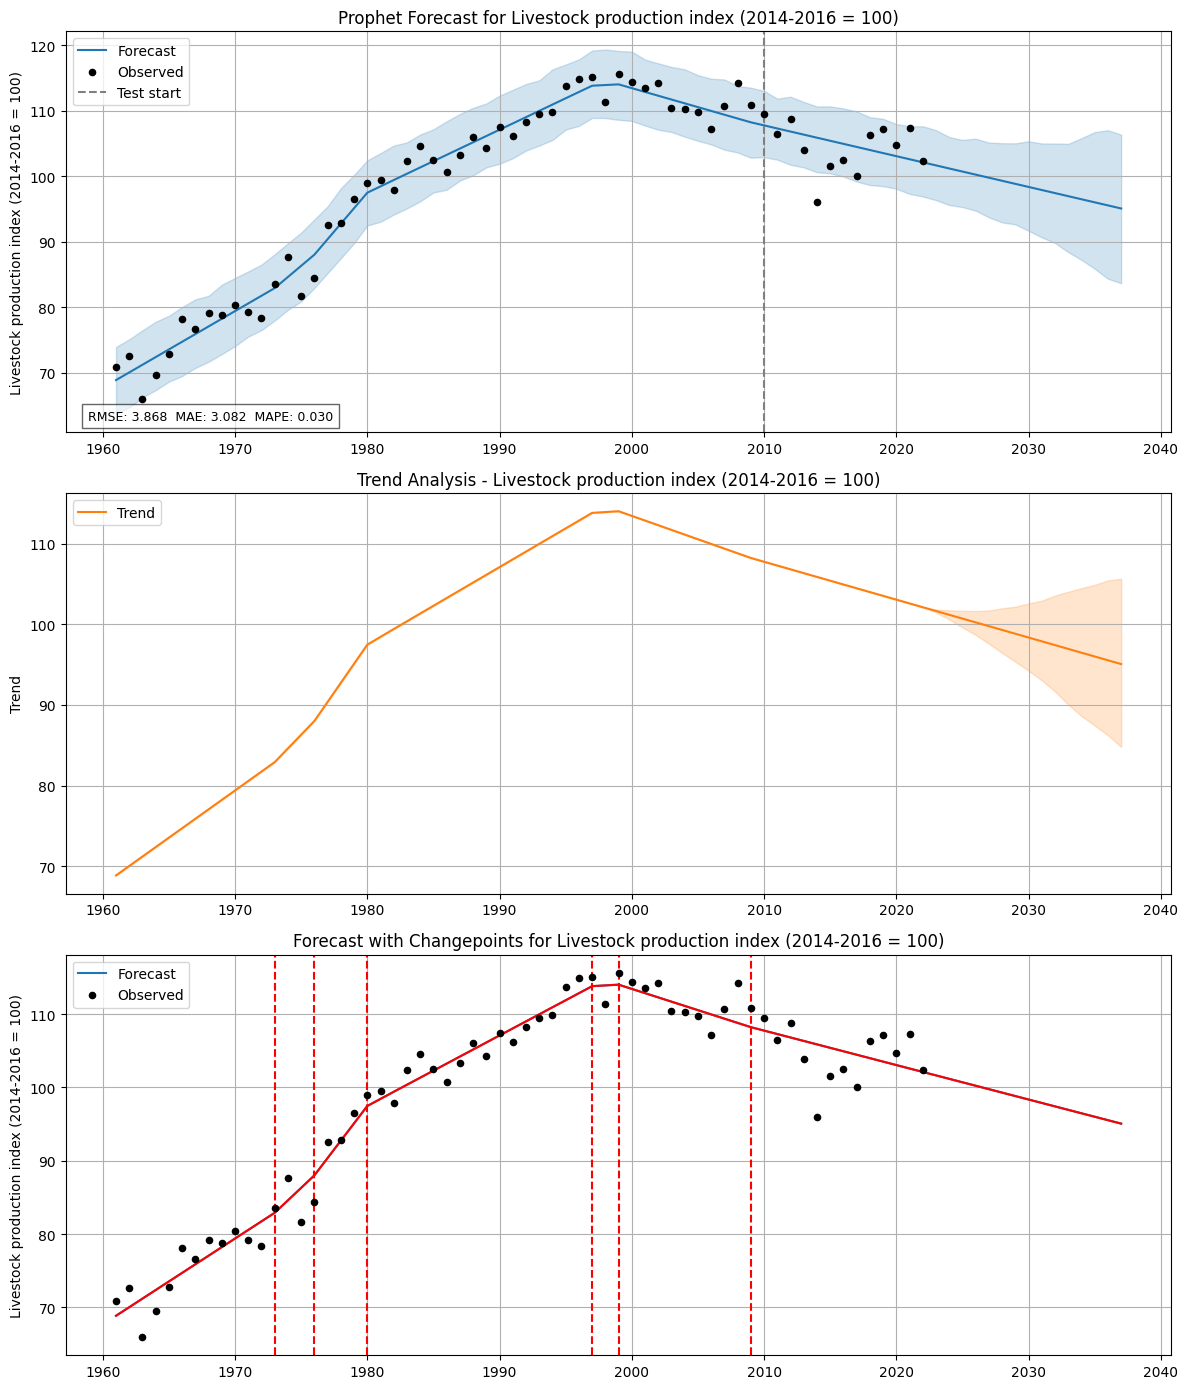



------------------------------FOOD PRODUCTION INDEX (2014-2016 = 100)------------------------------
Serie con 62 punti. Parametri CV impostati a:
Initial: 43 anni, Horizon: 12 anni, Period: 6 anni
PARAMETRI MIGLIORI TROVATI: {'growth': 'linear', 'changepoint_prior_scale': 0.5}
Creazione previsioni per 15 periodi futuri
Validation metrics (test) for Food production index (2014-2016 = 100): {'mse': np.float64(7.659165531545833), 'rmse': np.float64(2.767519743659624), 'mae': np.float64(1.9222633065848482), 'mape': np.float64(0.019371204346446007)}


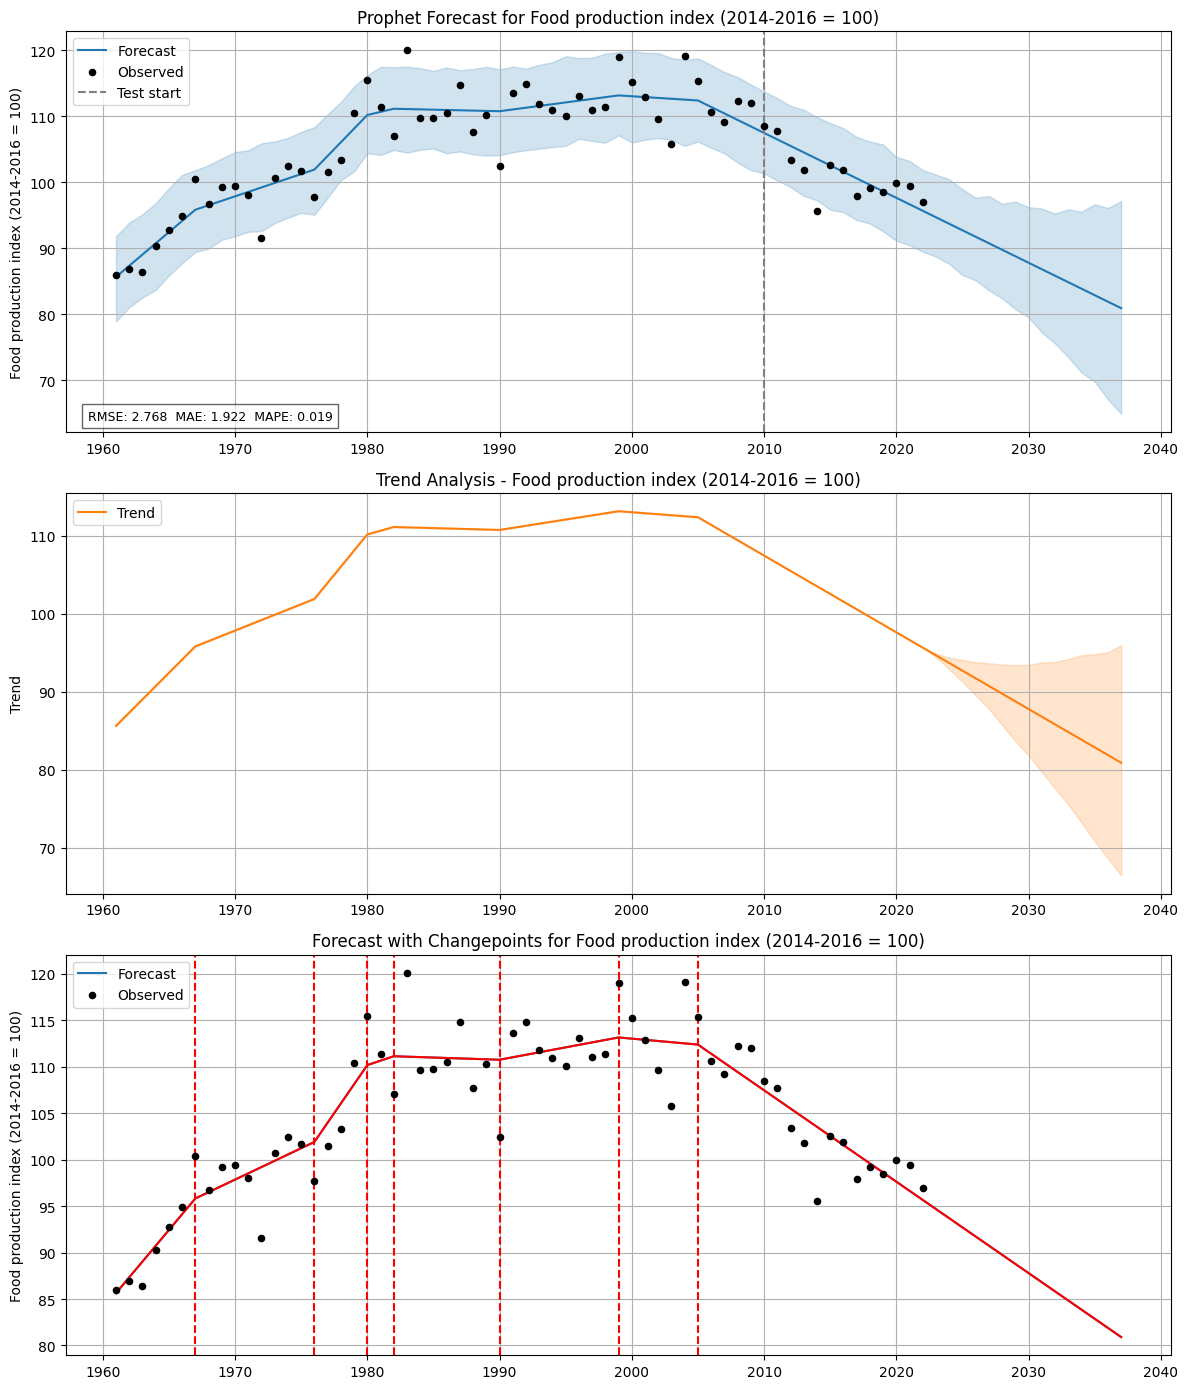



------------------------------CROP PRODUCTION INDEX (2014-2016 = 100)------------------------------
Serie con 62 punti. Parametri CV impostati a:
Initial: 43 anni, Horizon: 12 anni, Period: 6 anni
PARAMETRI MIGLIORI TROVATI: {'growth': 'linear', 'changepoint_prior_scale': 0.05}
Creazione previsioni per 15 periodi futuri
Validation metrics (test) for Crop production index (2014-2016 = 100): {'mse': np.float64(11.111667459784039), 'rmse': np.float64(3.3334167845896556), 'mae': np.float64(2.7362856676466683), 'mape': np.float64(0.027878914785996377)}


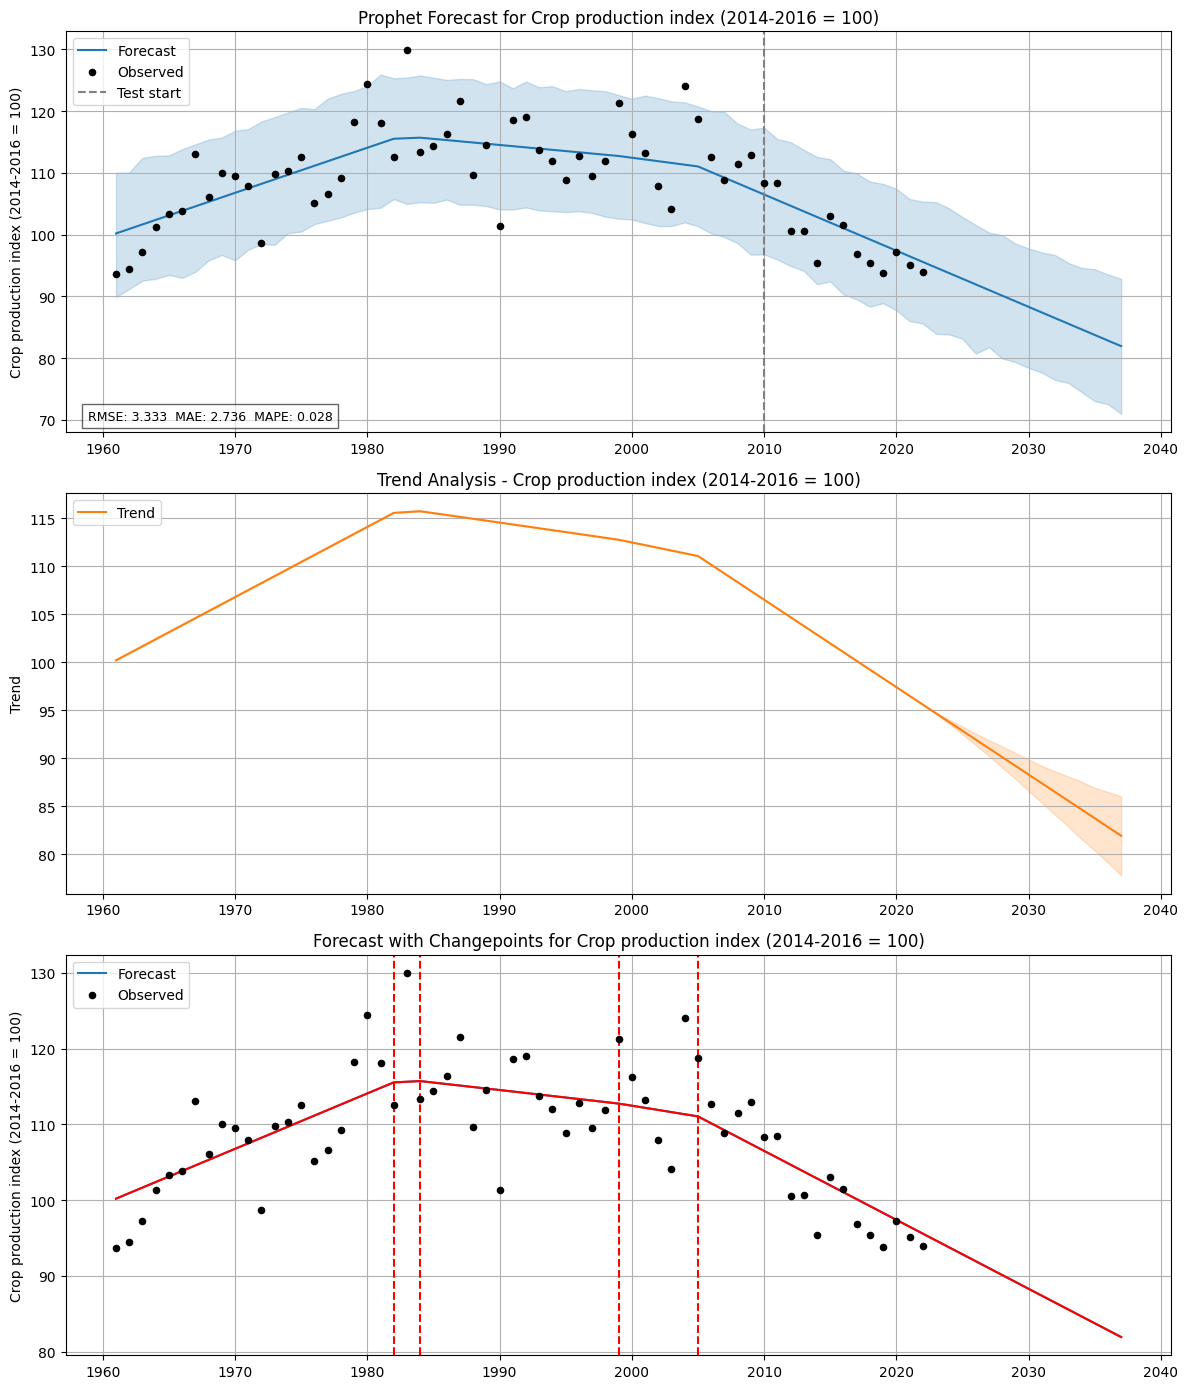



------------------------------CEREAL PRODUCTION (METRIC TONS)------------------------------
Serie con 62 punti. Parametri CV impostati a:
Initial: 43 anni, Horizon: 12 anni, Period: 6 anni
PARAMETRI MIGLIORI TROVATI: {'growth': 'linear', 'changepoint_prior_scale': 0.5}
Creazione previsioni per 15 periodi futuri
Validation metrics (test) for Cereal production (metric tons): {'mse': np.float64(525125009052.7614), 'rmse': np.float64(724655.0966168398), 'mae': np.float64(602744.6913152215), 'mape': np.float64(0.03520668498866693)}


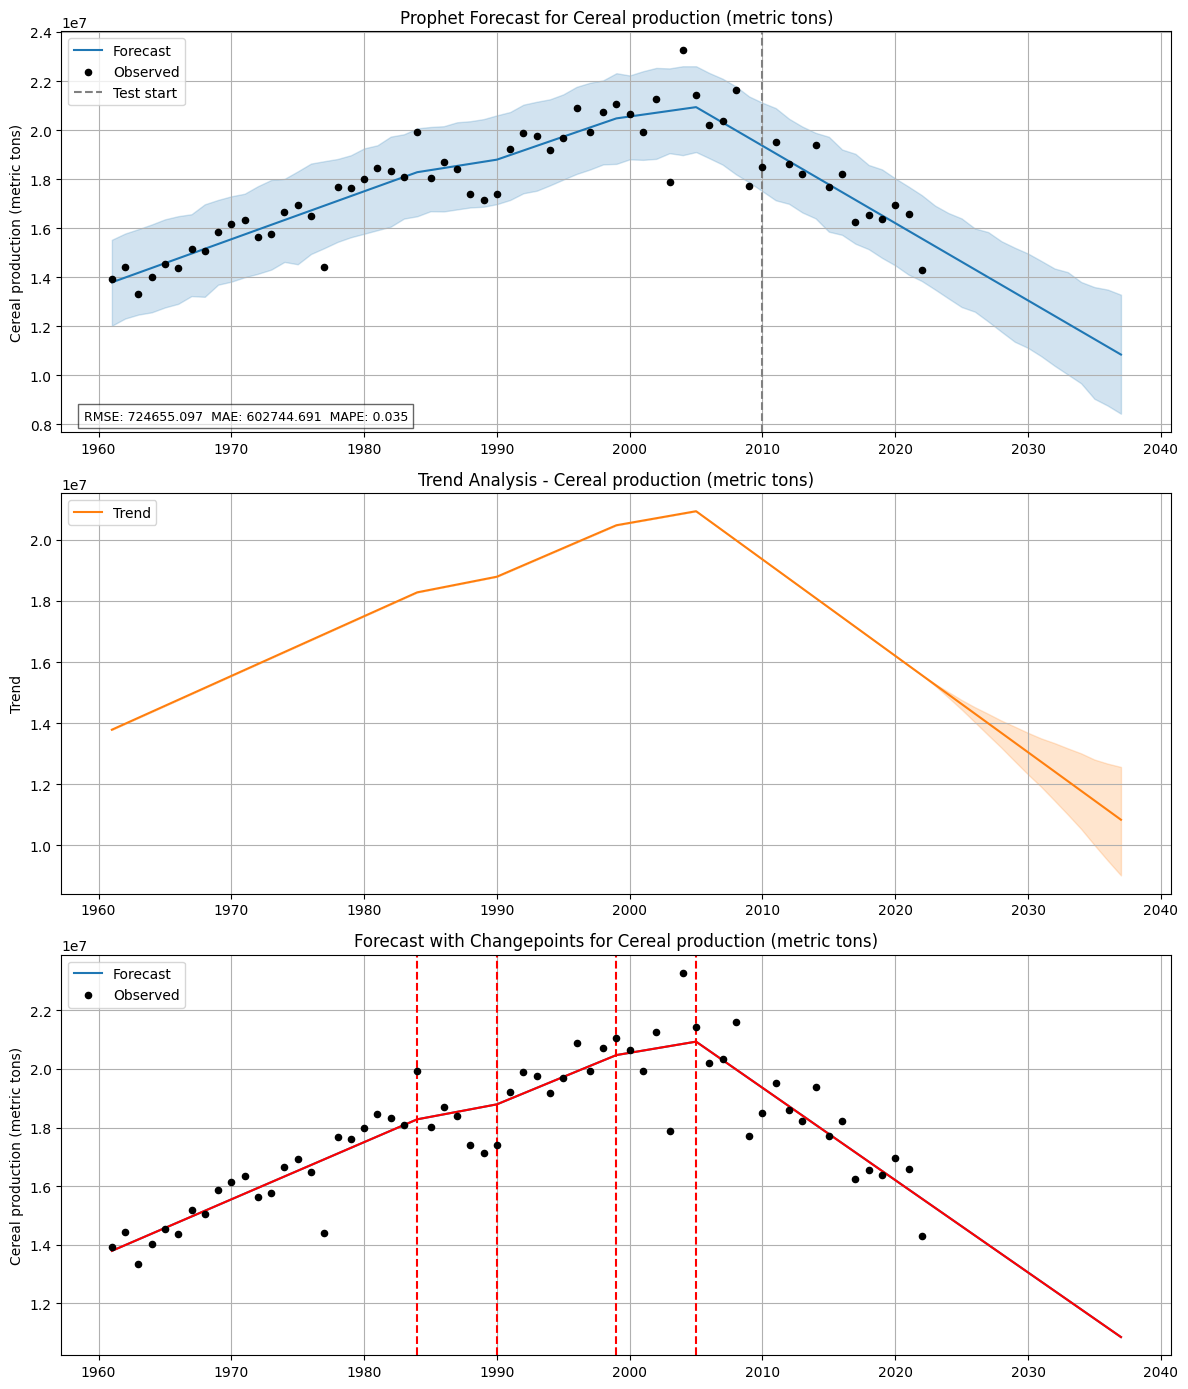



------------------------------CEREAL YIELD (KG PER HECTARE)------------------------------
Serie con 62 punti. Parametri CV impostati a:
Initial: 43 anni, Horizon: 12 anni, Period: 6 anni
PARAMETRI MIGLIORI TROVATI: {'growth': 'linear', 'changepoint_prior_scale': 0.01}
Creazione previsioni per 15 periodi futuri
Validation metrics (test) for Cereal yield (kg per hectare): {'mse': np.float64(193625.93177246943), 'rmse': np.float64(440.02946693655576), 'mae': np.float64(322.5932892760245), 'mape': np.float64(0.06194384833944619)}


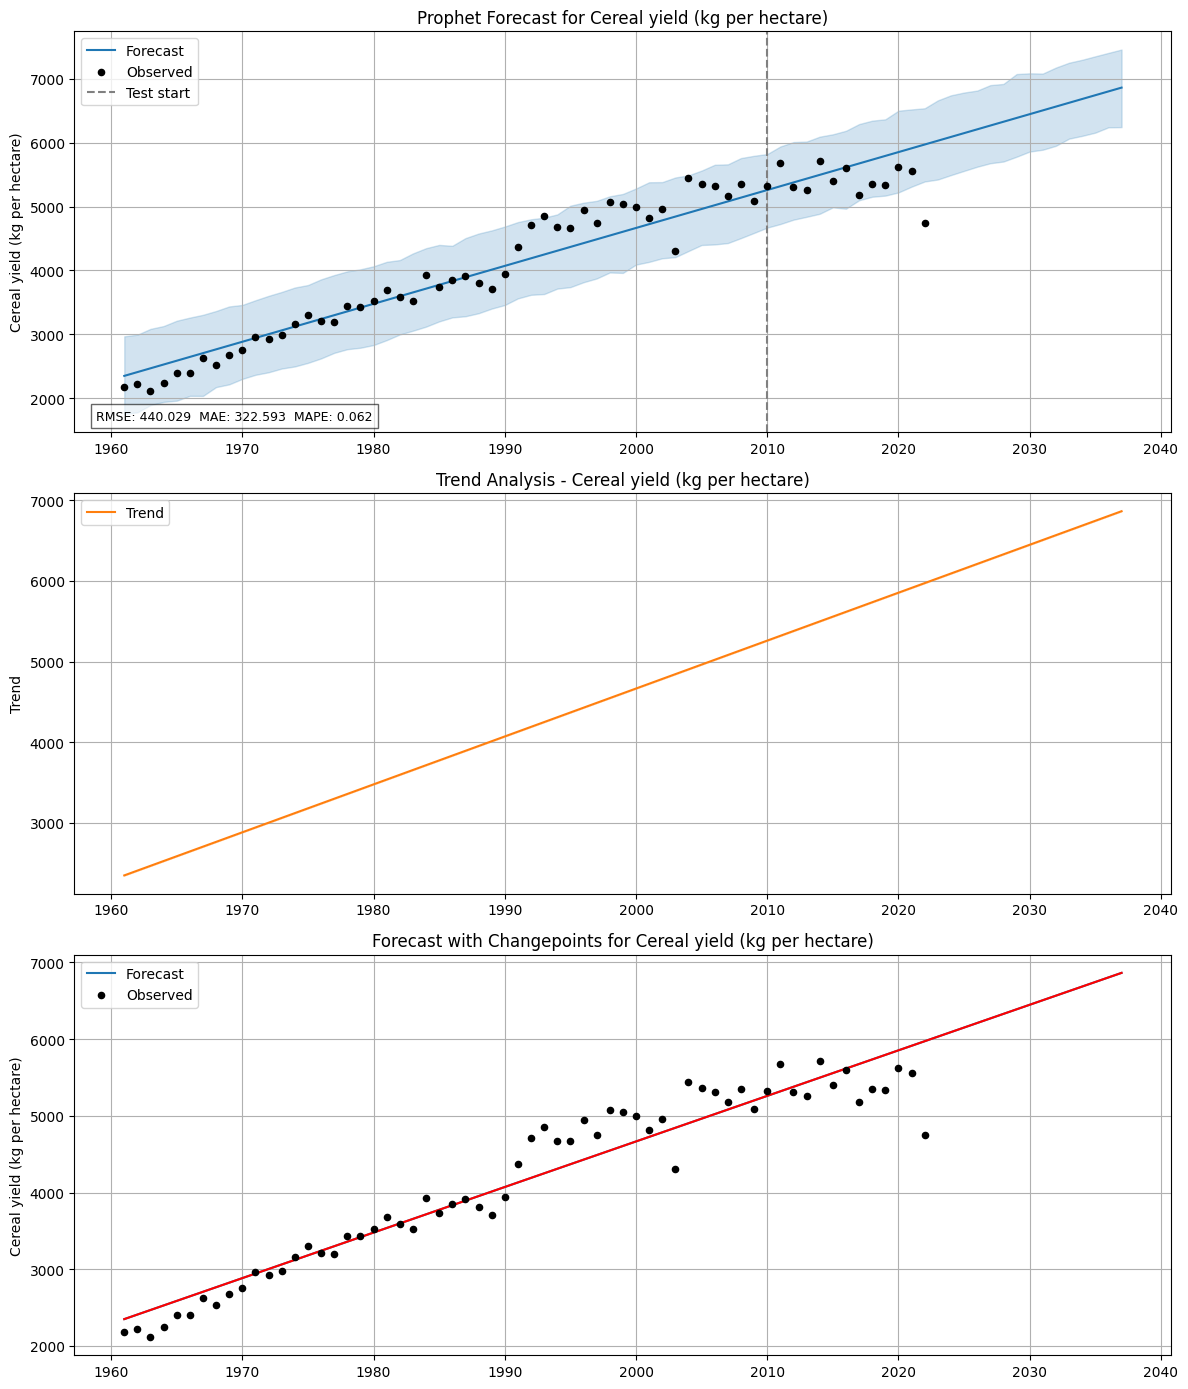



------------------------------AGRICULTURE, FORESTRY, AND FISHING, VALUE ADDED (% OF GDP)------------------------------
Serie con 35 punti. Parametri CV impostati a:
Initial: 24 anni, Horizon: 7 anni, Period: 3 anni
PARAMETRI MIGLIORI TROVATI: {'growth': 'linear', 'changepoint_prior_scale': 0.5}
Creazione previsioni per 15 periodi futuri
Validation metrics (test) for Agriculture, forestry, and fishing, value added (% of GDP): {'mse': np.float64(0.003040519201430756), 'rmse': np.float64(0.055140903161181136), 'mae': np.float64(0.04778210394808537), 'mape': np.float64(0.025102524403522904)}


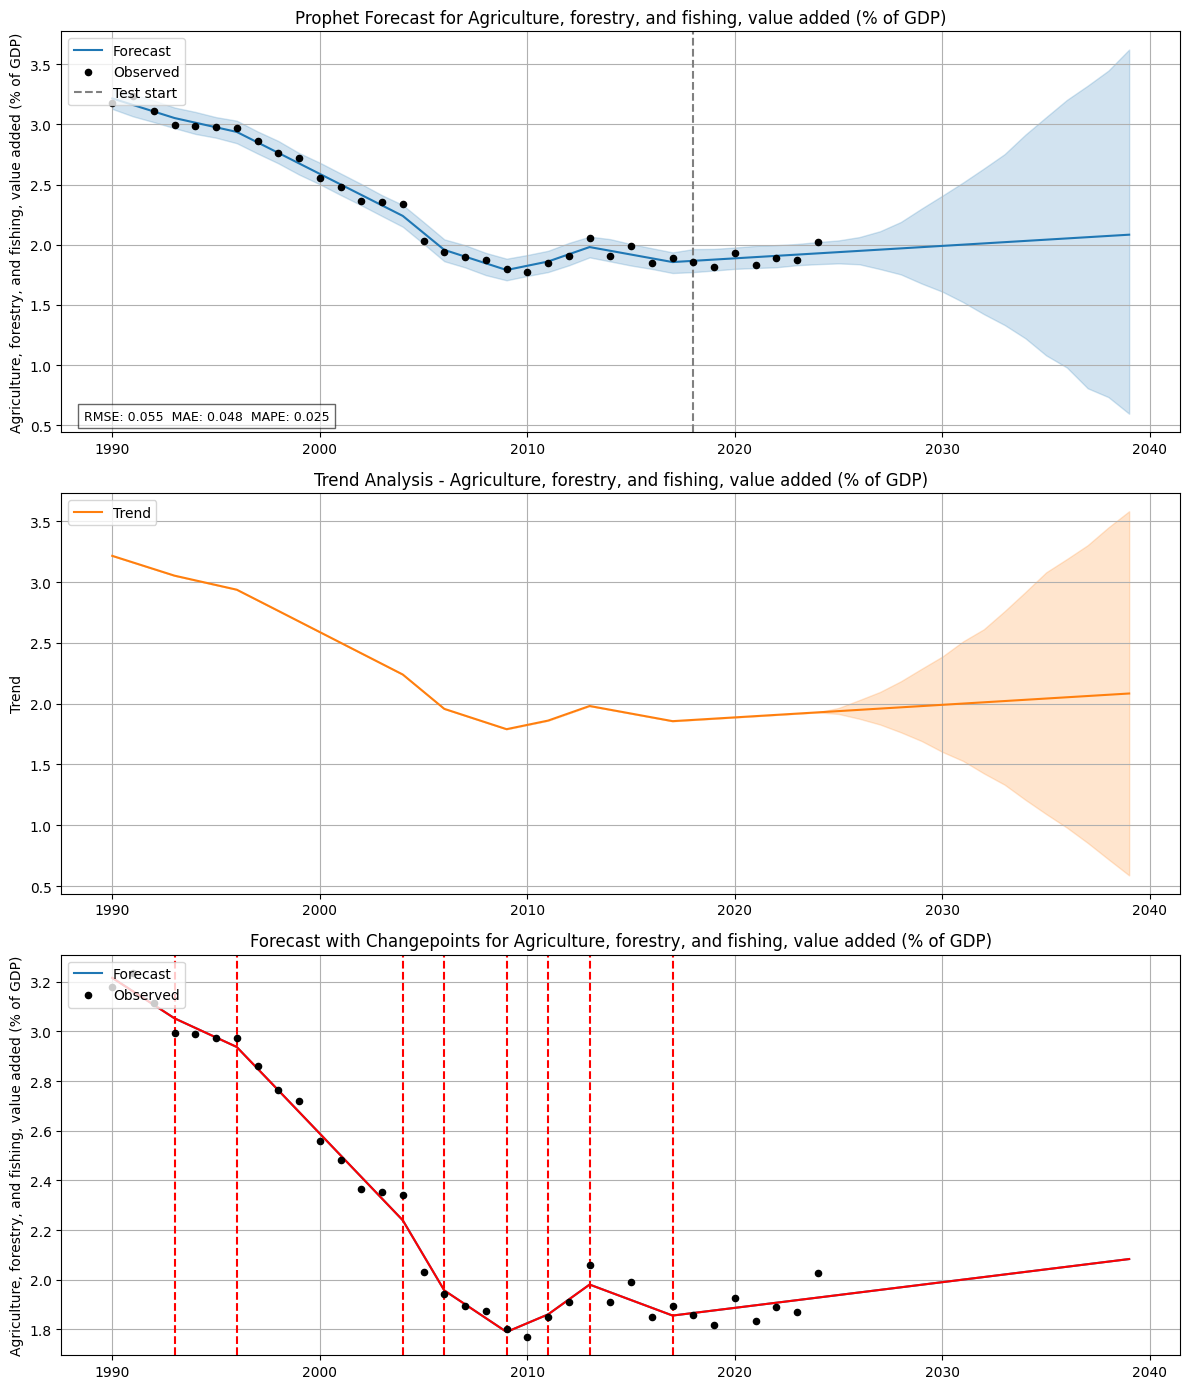



------------------------------AGRICULTURE, FORESTRY, AND FISHING, VALUE ADDED (CURRENT US$)------------------------------
Serie con 35 punti. Parametri CV impostati a:
Initial: 24 anni, Horizon: 7 anni, Period: 3 anni
PARAMETRI MIGLIORI TROVATI: {'growth': 'linear', 'changepoint_prior_scale': 0.05}
Creazione previsioni per 15 periodi futuri
Validation metrics (test) for Agriculture, forestry, and fishing, value added (current US$): {'mse': np.float64(1.1472250062576097e+19), 'rmse': np.float64(3387071015.283869), 'mae': np.float64(2728748051.220081), 'mape': np.float64(0.06605011619277366)}


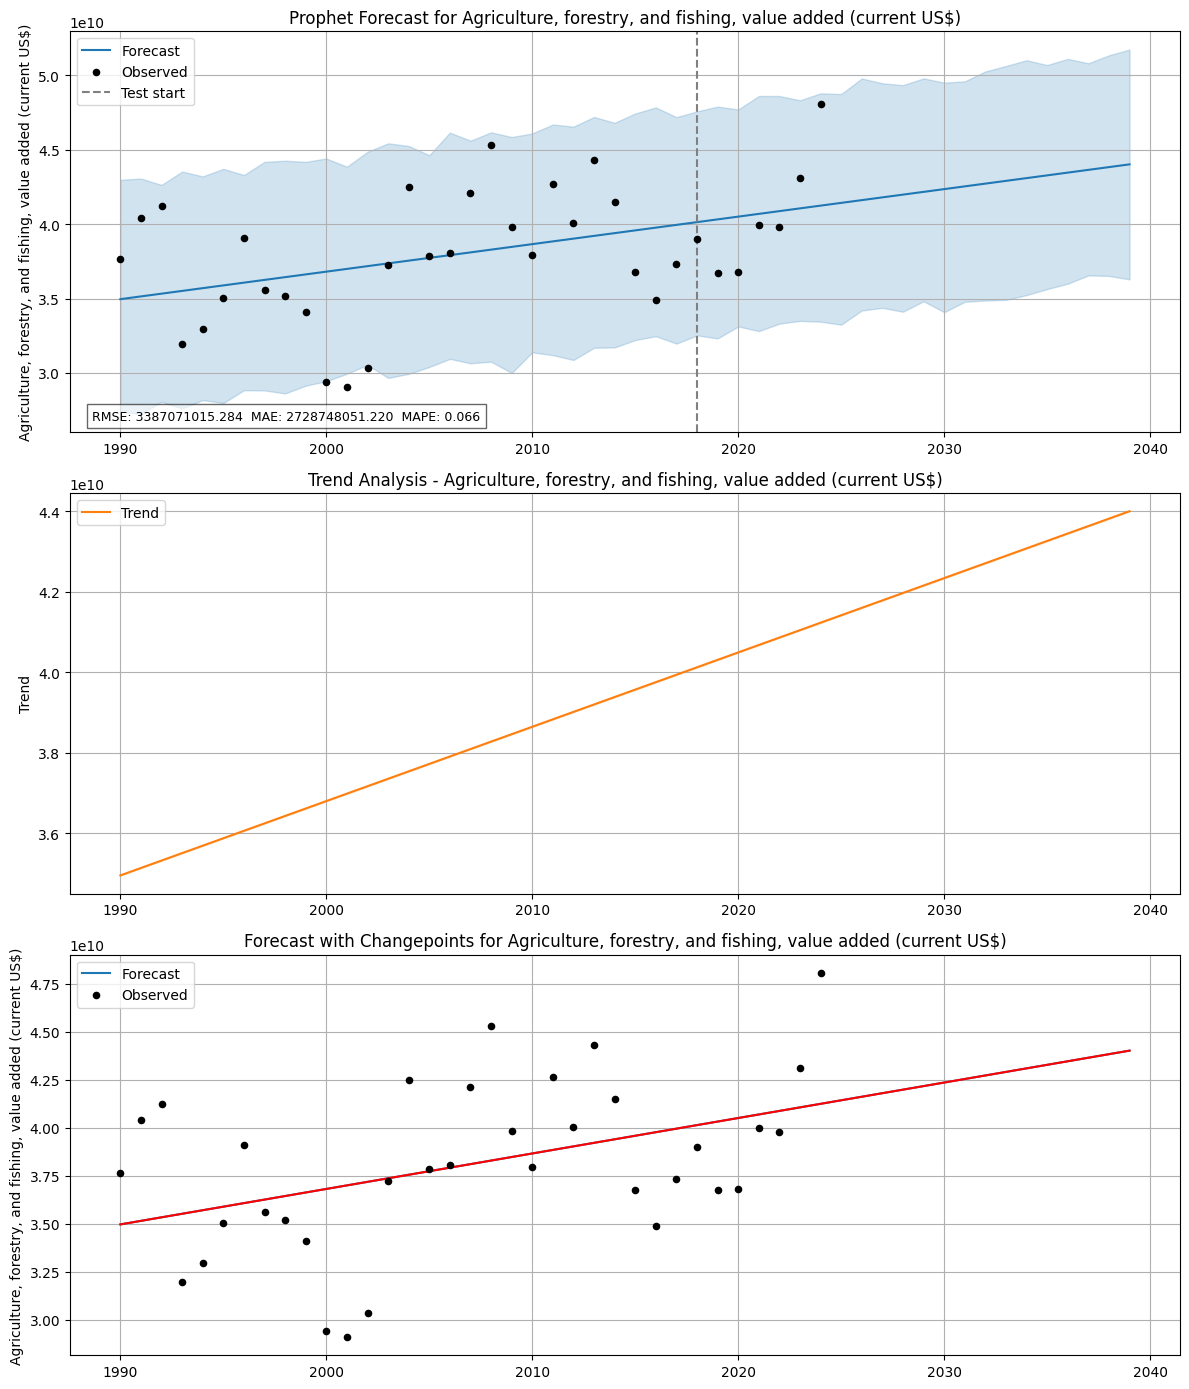



------------------------------AGRICULTURAL RAW MATERIALS EXPORTS (% OF MERCHANDISE EXPORTS)------------------------------
Serie con 63 punti. Parametri CV impostati a:
Initial: 44 anni, Horizon: 12 anni, Period: 6 anni
PARAMETRI MIGLIORI TROVATI: {'growth': 'linear', 'changepoint_prior_scale': 0.5}
Creazione previsioni per 15 periodi futuri
Validation metrics (test) for Agricultural raw materials exports (% of merchandise exports): {'mse': np.float64(0.0016195388627350657), 'rmse': np.float64(0.04024349466354861), 'mae': np.float64(0.03104160987510806), 'mape': np.float64(0.04413410274630709)}


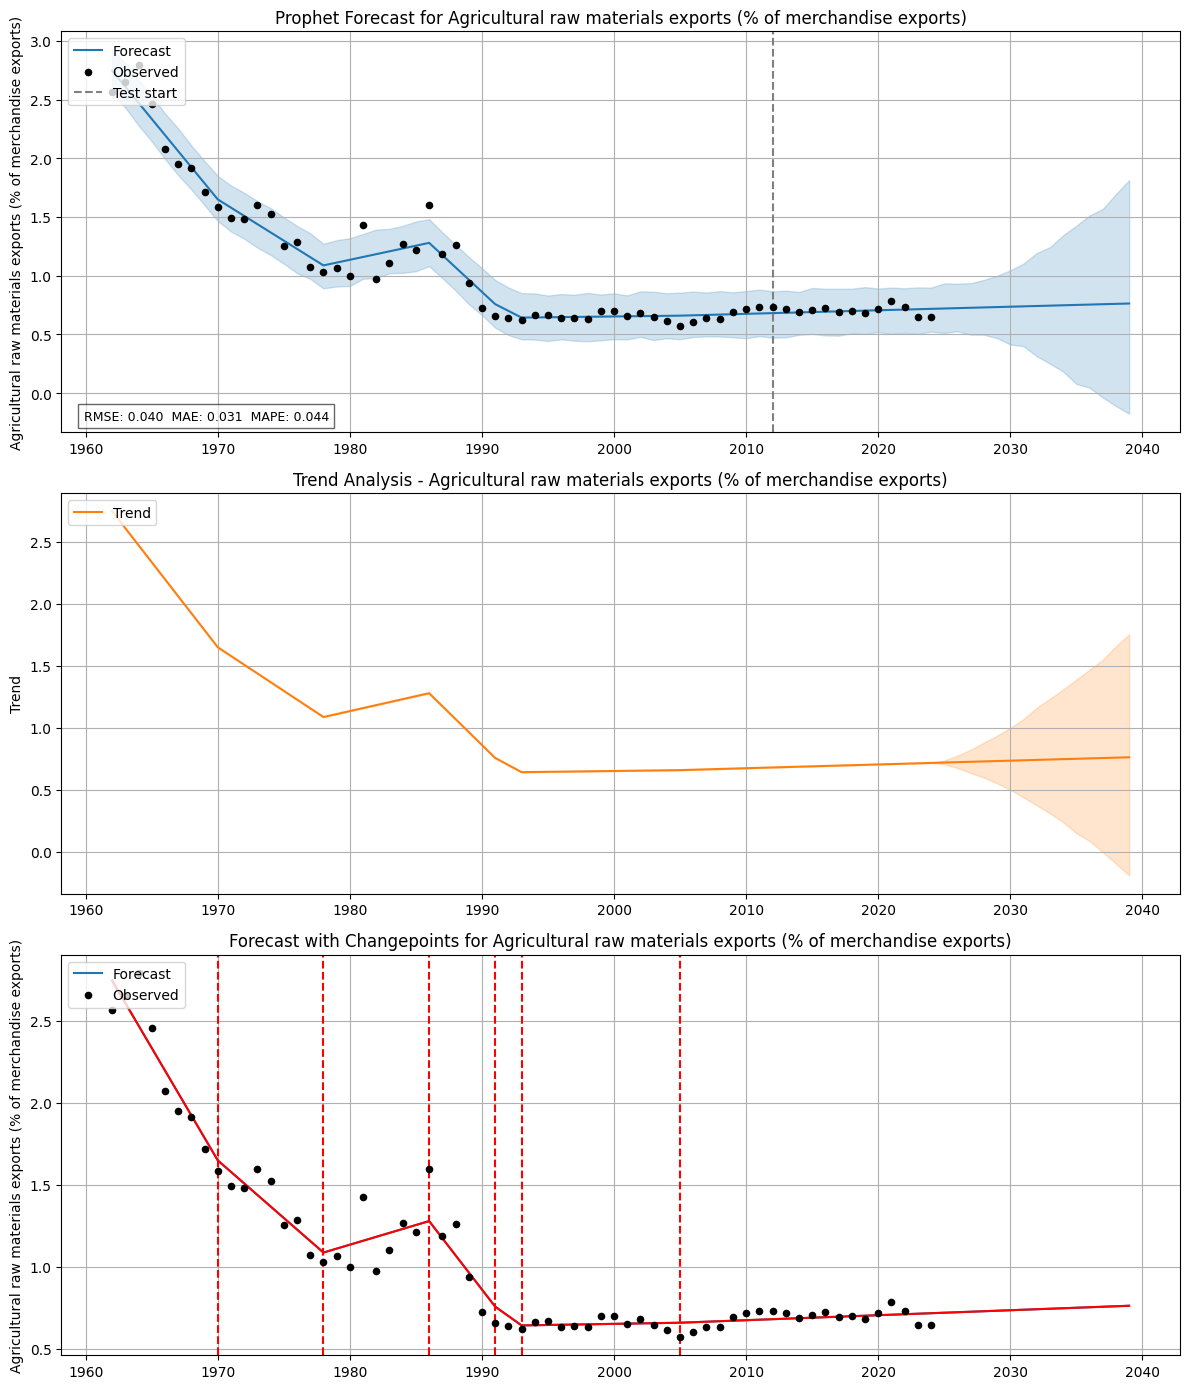



------------------------------AGRICULTURAL RAW MATERIALS IMPORTS (% OF MERCHANDISE IMPORTS)------------------------------
Serie con 63 punti. Parametri CV impostati a:
Initial: 44 anni, Horizon: 12 anni, Period: 6 anni
PARAMETRI MIGLIORI TROVATI: {'growth': 'linear', 'changepoint_prior_scale': 0.1}
Creazione previsioni per 15 periodi futuri
Validation metrics (test) for Agricultural raw materials imports (% of merchandise imports): {'mse': np.float64(0.017203213181099238), 'rmse': np.float64(0.13116102005206898), 'mae': np.float64(0.11188033030326497), 'mape': np.float64(0.05432923002407054)}


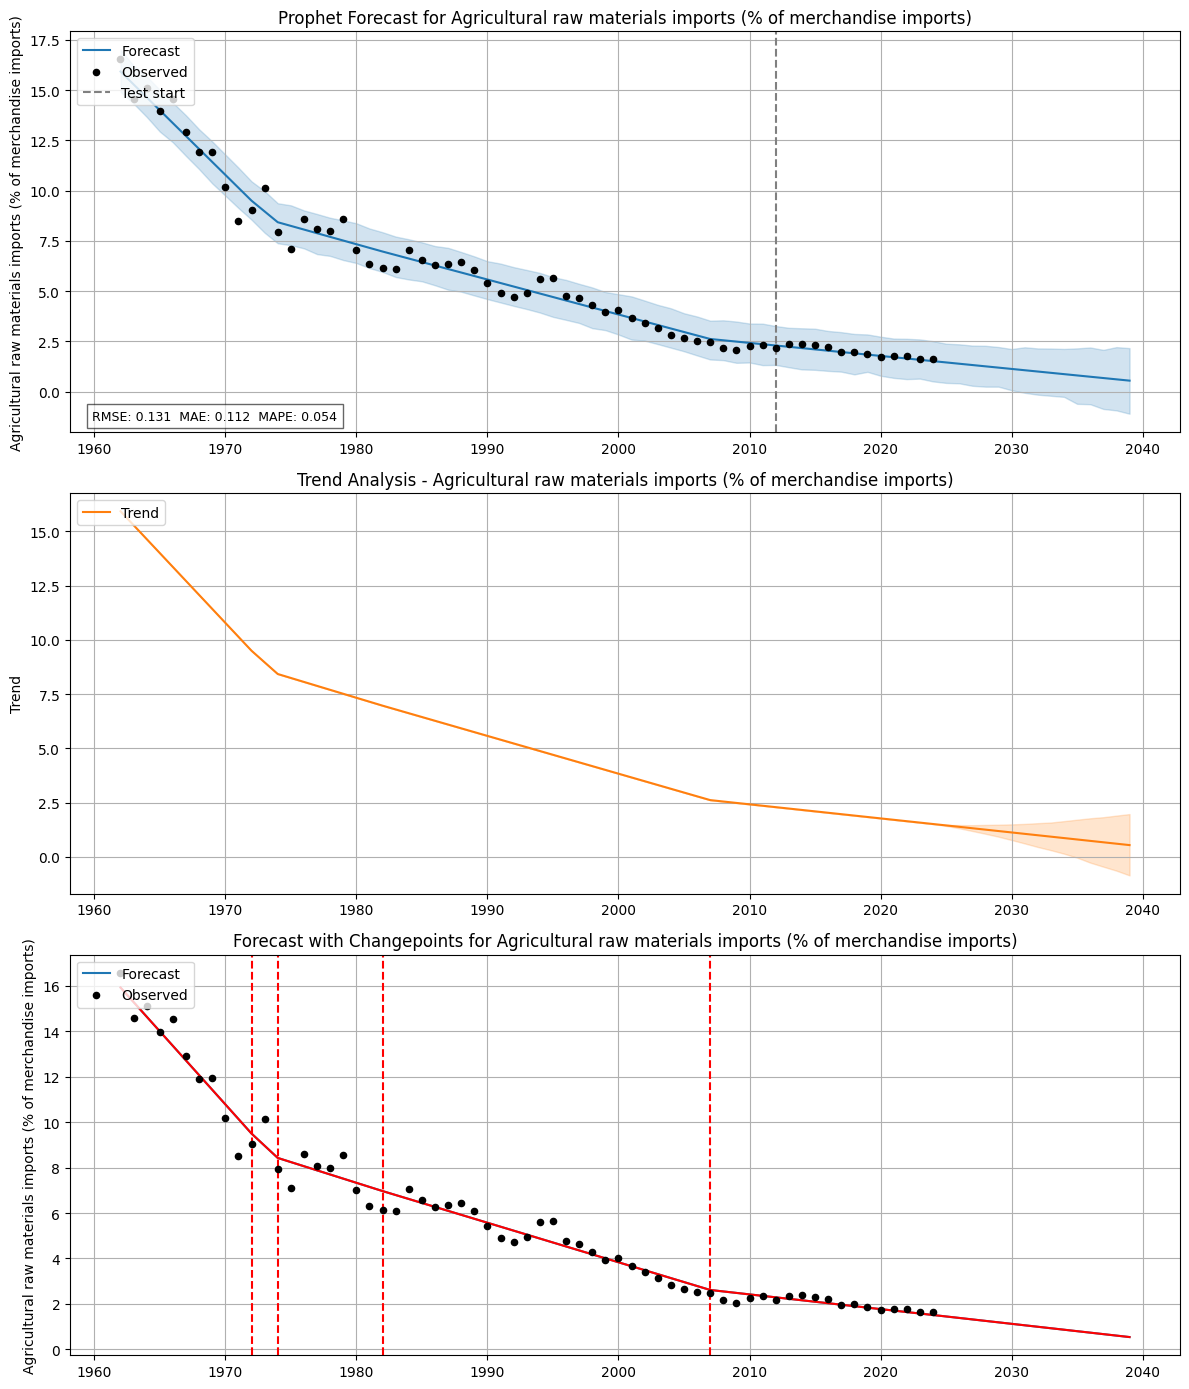

In [40]:
import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
logging.getLogger('prophet').setLevel(logging.WARNING)

for col in wide_df.columns:
    if col == 'ds':
        continue
    if not np.issubdtype(wide_df[col].dtype, np.number):
        print(f"Skipping {col}: non-numeric dtype")
        continue
    if wide_df[col].dropna().empty:
        print(f"Skipping {col}: all NaN")
        continue
    print(f"{'-'*30}{col.upper()}{'-'*30}")
    df_prophet = preprocessing(col, wide_df)
    
    split_idx = int(len(df_prophet)*0.8)
    train = df_prophet[:split_idx]
    test = df_prophet[split_idx:]
    final_model, optimal_params = fit_adaptive_prophet(df_prophet)
    forecast_df = generate_forecast_and_plots(col, final_model)
    print('\n')